# Decision program using machine learning methods

Classification - 2 classes (Accuracy):
*  Decision tree: 78.26%
*  Random forest: 78.26%
*  SVM: 78.26% (poly)
*  kNN: 69.57%
*  MLP: 78.26%

Classification - 3 classes (Accuracy):
*  Decision tree: 56.52% (cut-off 0.05), 78.26 (cut-off 0.01)
*  Random forest: 69.57& (cut-off 0.05), 78.62 (cut-off 0.01)
*  SVM: 69.57& (cut-off 0.05, poly or rbf kernel), 78.62 (cut-off 0.01, linear and poly kernel)
*  kNN: 60.87% (cut-off 0.05), 69.57% (cut-off 0.01)
*  MLP: 60.87% (cut-off 0.05), 69.57%(cut-off 0.01)

Regression (MSE):
*  Decision tree: 0.1650
*  Random forest: 0.6296
*  SVM: 0.9384 (linear kernel)
*  kNN: 0.4436
*  Multi Layer Perceptron MLP:
   *  4 layers: 0.7062 rate: 0.1, epochs: 100)

Train set as train and as validation set:  
*  Accuracy for two classes: **100%** (decision tree or random forest)
*  Accuracy for three classes: **100%** (decision tree or random forest, cut-off 0.05), **100%** (decision tree or random forest, cut-off 0.01)
*  MSE for time difference: **0.11** (random forest)

In [1]:
!pip install scikit-learn
!pip install statsmodels
!pip install matplotlib
!pip install seaborn
!pip install torch
!pip install tqdm

In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import cross_val_predict
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import KNeighborsRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error
from sklearn.neural_network import MLPRegressor
from sklearn.neural_network import MLPClassifier
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch import nn
from torch.utils.data import DataLoader

### Import the data

In [3]:
file_path = 'results/features_times_augment.csv'
df = pd.read_csv(file_path)
df.head()

,bench,query,orig/rewr(mean),orig/rewr+rewr(mean),orig mean,rewr mean,rewr mean+rewr,diff rewr-orig,diff rewr+rewr-orig,#relations,...,min(branching factors),max(branching factors),mean(branching factors),median(branching factors),balancedness factor,list table rows,list join rows,container counts list,branching factors list,text
0,STATS,001-014,orig,orig,0.025373,0.051895,1.977303,0.026522,1.951929,3,...,2,2,2.0,2.0,1.0,"[99733, 969, 31480]","[24066, 81]","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3]",[2],"SELECT MIN(u.Id) FROM comments as c, votes as ..."
1,STATS,001-014-augA1,orig,orig,0.027259,0.041034,1.837866,0.013775,1.810608,3,...,1,1,1.0,1.0,NaN,"[99733, 969, 31480]","[24066, 81]","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3]","[1, 1]","SELECT MIN(c.id) FROM comments as c, votes as ..."
2,STATS,001-014-augA2,orig,orig,0.027502,0.056328,1.874659,0.028826,1.847156,3,...,1,1,1.0,1.0,NaN,"[99733, 969, 31480]","[24066, 81]","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3]","[1, 1]","SELECT MIN(v.id) FROM comments as c, votes as ..."
3,STATS,001-014-augF1,orig,orig,0.024752,0.048523,1.880818,0.023772,1.856066,3,...,2,2,2.0,2.0,1.0,"[99733, 728, 31480]","[18090, 61]","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3]",[2],"SELECT MIN(u.Id) FROM comments as c, votes as ..."
4,STATS,001-014-augF1-augA1,orig,orig,0.024448,0.039470,1.894473,0.015023,1.870025,3,...,1,1,1.0,1.0,NaN,"[99733, 728, 31480]","[18090, 61]","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3]","[1, 1]","SELECT MIN(c.id) FROM comments as c, votes as ..."


**Get only the queries we had before augmentation**

In [4]:
df = df[~df['query'].str.contains('aug')][:-38]
df

,bench,query,orig/rewr(mean),orig/rewr+rewr(mean),orig mean,rewr mean,rewr mean+rewr,diff rewr-orig,diff rewr+rewr-orig,#relations,...,min(branching factors),max(branching factors),mean(branching factors),median(branching factors),balancedness factor,list table rows,list join rows,container counts list,branching factors list,text
0,STATS,001-014,orig,orig,0.025373,0.051895,1.977303,0.026522,1.951929,3,...,2,2,2.0,2.0,1.000000,"[99733, 969, 31480]","[24066, 81]","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3]",[2],"SELECT MIN(u.Id) FROM comments as c, votes as ..."
9,STATS,002-048,orig,orig,0.066407,0.119431,1.928187,0.053025,1.861780,5,...,1,3,2.0,2.0,1.000000,"[101755, 192979, 268, 31527, 79851]","[81277596, 98639, 10171, 194]","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[3, 1]","SELECT MIN(c.Id) FROM comments as c, postHisto..."
24,STATS,003-067,orig,orig,0.046820,0.137277,2.032372,0.090457,1.985552,6,...,5,5,5.0,5.0,1.000000,"[192979, 78165, 25426, 10013, 1334, 38465]","[3421, 55, 58, 40, 145]","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",[5],"SELECT MIN(c.Id) FROM comments as c, posts as ..."
42,STATS,004-041,orig,orig,0.021953,0.053818,1.782038,0.031865,1.760085,4,...,1,2,1.5,1.5,1.000000,"[79668, 10726, 771, 36453]","[158, 80, 90]","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[2, 1]","SELECT MIN(pl.Id) FROM postLinks as pl, posts ..."
54,STATS,005-024,orig,orig,0.023235,0.045902,1.994790,0.022667,1.971555,3,...,2,2,2.0,2.0,1.000000,"[79851, 728, 39595]","[305, 76]","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3]",[2],"SELECT MIN(v.Id) FROM votes as v, badges as b,..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2535,HETIO,3-17-CuGdCtD,orig,orig,0.104910,0.260577,2.334114,0.155667,2.229204,7,...,1,3,2.0,2.0,0.625000,"[146276, 1552, 154076, 1510, 137, 1552, 20945]","[385882, 20428, 2258, 2258, 446, 446]","[1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 3]","[1, 3, 2]","SELECT MIN(c1.nid) FROM compound c1, upregulat..."
2542,HETIO,3-18-CuGuCtD,orig,orig,0.149254,0.252073,2.240618,0.102819,2.091365,7,...,1,3,2.0,2.0,0.666667,"[146276, 1552, 146276, 1510, 137, 1552, 20945]","[428982, 20428, 2454, 2454, 446, 446]","[1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 3]","[1, 2, 3]","SELECT MIN(c1.nid) FROM compound c1, upregulat..."
2549,HETIO,4-01-CbGiGiGaD,rewr,rewr,10.130912,0.976408,2.989730,-9.154504,-7.141182,9,...,1,3,2.0,2.0,0.500000,"[173134, 20945, 23142, 1552, 173134, 25246, 13...","[5006428, 219851, 173134, 11669, 11754, 11754,...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 3]","[2, 1, 3, 2]","SELECT MIN(c.nid) FROM compound c, binds b, ge..."
2558,HETIO,4-02-CbGpBPpGaD,rewr,rewr,47.491817,1.600161,3.640768,-45.891656,-43.851050,9,...,1,3,2.0,2.0,0.500000,"[12321, 23142, 1552, 678887, 678887, 25246, 13...","[2593014, 664751, 6864, 11669, 17596, 25534, 6...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 3]","[1, 2, 3, 2]","SELECT MIN(c.nid) FROM compound c, binds b, ge..."


In [5]:
df.dtypes

bench                         object
query                         object
orig/rewr(mean)               object
orig/rewr+rewr(mean)          object
orig mean                    float64
rewr mean                    float64
rewr mean+rewr               float64
diff rewr-orig               float64
diff rewr+rewr-orig          float64
#relations                     int64
#conditions                    int64
#filters                       int64
#joins                         int64
total cost                   float64
min(table rows)                int64
max(table rows)                int64
mean(table rows)             float64
q25(table rows)              float64
median(table rows)           float64
q75(table rows)              float64
min(join rows)                 int64
max(join rows)                object
mean(join rows)              float64
q25(join rows)               float64
median(join rows)            float64
q75(join rows)               float64
depth                          int64
m

In [6]:
df['max(join rows)'] = df['max(join rows)'].astype("float64")

#### Delete those examples, where both methods gave a timeout

In [7]:
df[df["orig/rewr(mean)"] == "-"]

,bench,query,orig/rewr(mean),orig/rewr+rewr(mean),orig mean,rewr mean,rewr mean+rewr,diff rewr-orig,diff rewr+rewr-orig,#relations,...,min(branching factors),max(branching factors),mean(branching factors),median(branching factors),balancedness factor,list table rows,list join rows,container counts list,branching factors list,text
2077,SNAP,wiki-path06,-,-,100.0,100.0,100.0,0.0,0.0,7,...,1,2,1.200000,1.0,1.000000,"[11879844, 28511626, 28511626, 28511626, 28511...","[326762260512167952384, 62304772963830, 206402...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2]","[1, 1, 1, 1, 2]","select MIN(p1.toNode) from wiki p1, wiki p2, w..."
2084,SNAP,wiki-path07,-,-,100.0,100.0,100.0,0.0,0.0,8,...,1,2,1.166667,1.0,1.000000,"[11879844, 28511626, 28511626, 28511626, 28511...","[56772159792588989136896, 62304772963830, 2064...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2]","[1, 1, 1, 1, 1, 2]","select MIN(p1.toNode) from wiki p1, wiki p2, w..."
2092,SNAP,wiki-path08,-,-,100.0,100.0,100.0,0.0,0.0,9,...,1,2,1.142857,1.0,1.000000,"[11879844, 28511626, 28511626, 28511626, 28511...","[9863679246383583674236928, 10824923664683172,...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[1, 1, 1, 1, 1, 1, 2]","select MIN(p1.toNode) from wiki p1, wiki p2, w..."
2112,SNAP,wiki-tree03,-,-,100.0,100.0,100.0,0.0,0.0,8,...,1,3,1.750000,1.5,0.666667,"[11879844, 28511626, 28511626, 28511626, 28511...","[56772159792588989136896, 10824923664683172, 3...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 3]","[1, 1, 2, 3]","select MIN(p1.toNode) from wiki p1, wiki p2a, ..."


For the SNAP dataset the wiki-path06, wiki-path07, wiki-path08 and wiki-tree03 (for all augmentation cases) did not finish the evaluation within our timeout (100 sec). Therefore, we cannot conclude which variante is the better one and we delete those 32 samples.

In [8]:
df = df[df["orig/rewr(mean)"] != "-"]
df.shape

(225, 43)

#### Get the feature matrix

Get the features matrix X and the response variables y1 and y1, where once the rewritting time and the evaluation time are taken into consideration and once only the evaluation time. Additionally the response variables have to have numbers in it and we assign 1 = rewr and 0 = orig.

In [9]:
X = df.iloc[:, 9:37]
X.head()

,#relations,#conditions,#filters,#joins,total cost,min(table rows),max(table rows),mean(table rows),q25(table rows),median(table rows),...,min(container counts),max(container counts),mean(container counts),q25(container counts),median(container counts),q75(container counts),min(branching factors),max(branching factors),mean(branching factors),median(branching factors)
0,3,7,5,2,9607.31,969,99733,44060.666667,16224.50,31480.0,...,1,3,1.133333,1.0,1.0,1.0,2,2,2.0,2.0
9,5,7,3,4,223292.04,268,192979,81276.000000,31527.00,79851.0,...,1,5,1.190476,1.0,1.0,1.0,1,3,2.0,2.0
24,6,17,12,5,17194.35,1334,192979,57730.333333,13866.25,31945.5,...,1,4,1.156250,1.0,1.0,1.0,5,5,5.0,5.0
42,4,15,12,3,6580.11,771,79668,31904.500000,8237.25,23589.5,...,1,3,1.142857,1.0,1.0,1.0,1,2,1.5,1.5
54,3,5,3,2,8525.96,728,79851,40058.000000,20161.50,39595.0,...,1,3,1.153846,1.0,1.0,1.0,2,2,2.0,2.0


#### Log-transformations

Some of the features have a big range of possible values. Therefore, we log transform those.

In [10]:
min_values = X.min()
max_values = X.max()
diff = max_values-min_values

pd.DataFrame({'Min': min_values, 'Max': max_values, 'Diff': diff})

,Min,Max,Diff
#relations,2.000000,1.000000e+01,8.000000e+00
#conditions,2.000000,2.000000e+01,1.800000e+01
#filters,0.000000,1.600000e+01,1.600000e+01
#joins,1.000000,1.200000e+01,1.100000e+01
total cost,209.970000,8.739948e+16,8.739948e+16
min(table rows),1.000000,1.187984e+07,1.187984e+07
max(table rows),21.000000,2.851163e+07,2.851160e+07
mean(table rows),5.200000,2.573966e+07,2.573966e+07
q25(table rows),1.000000,2.851163e+07,2.851162e+07
median(table rows),1.000000,2.851163e+07,2.851162e+07


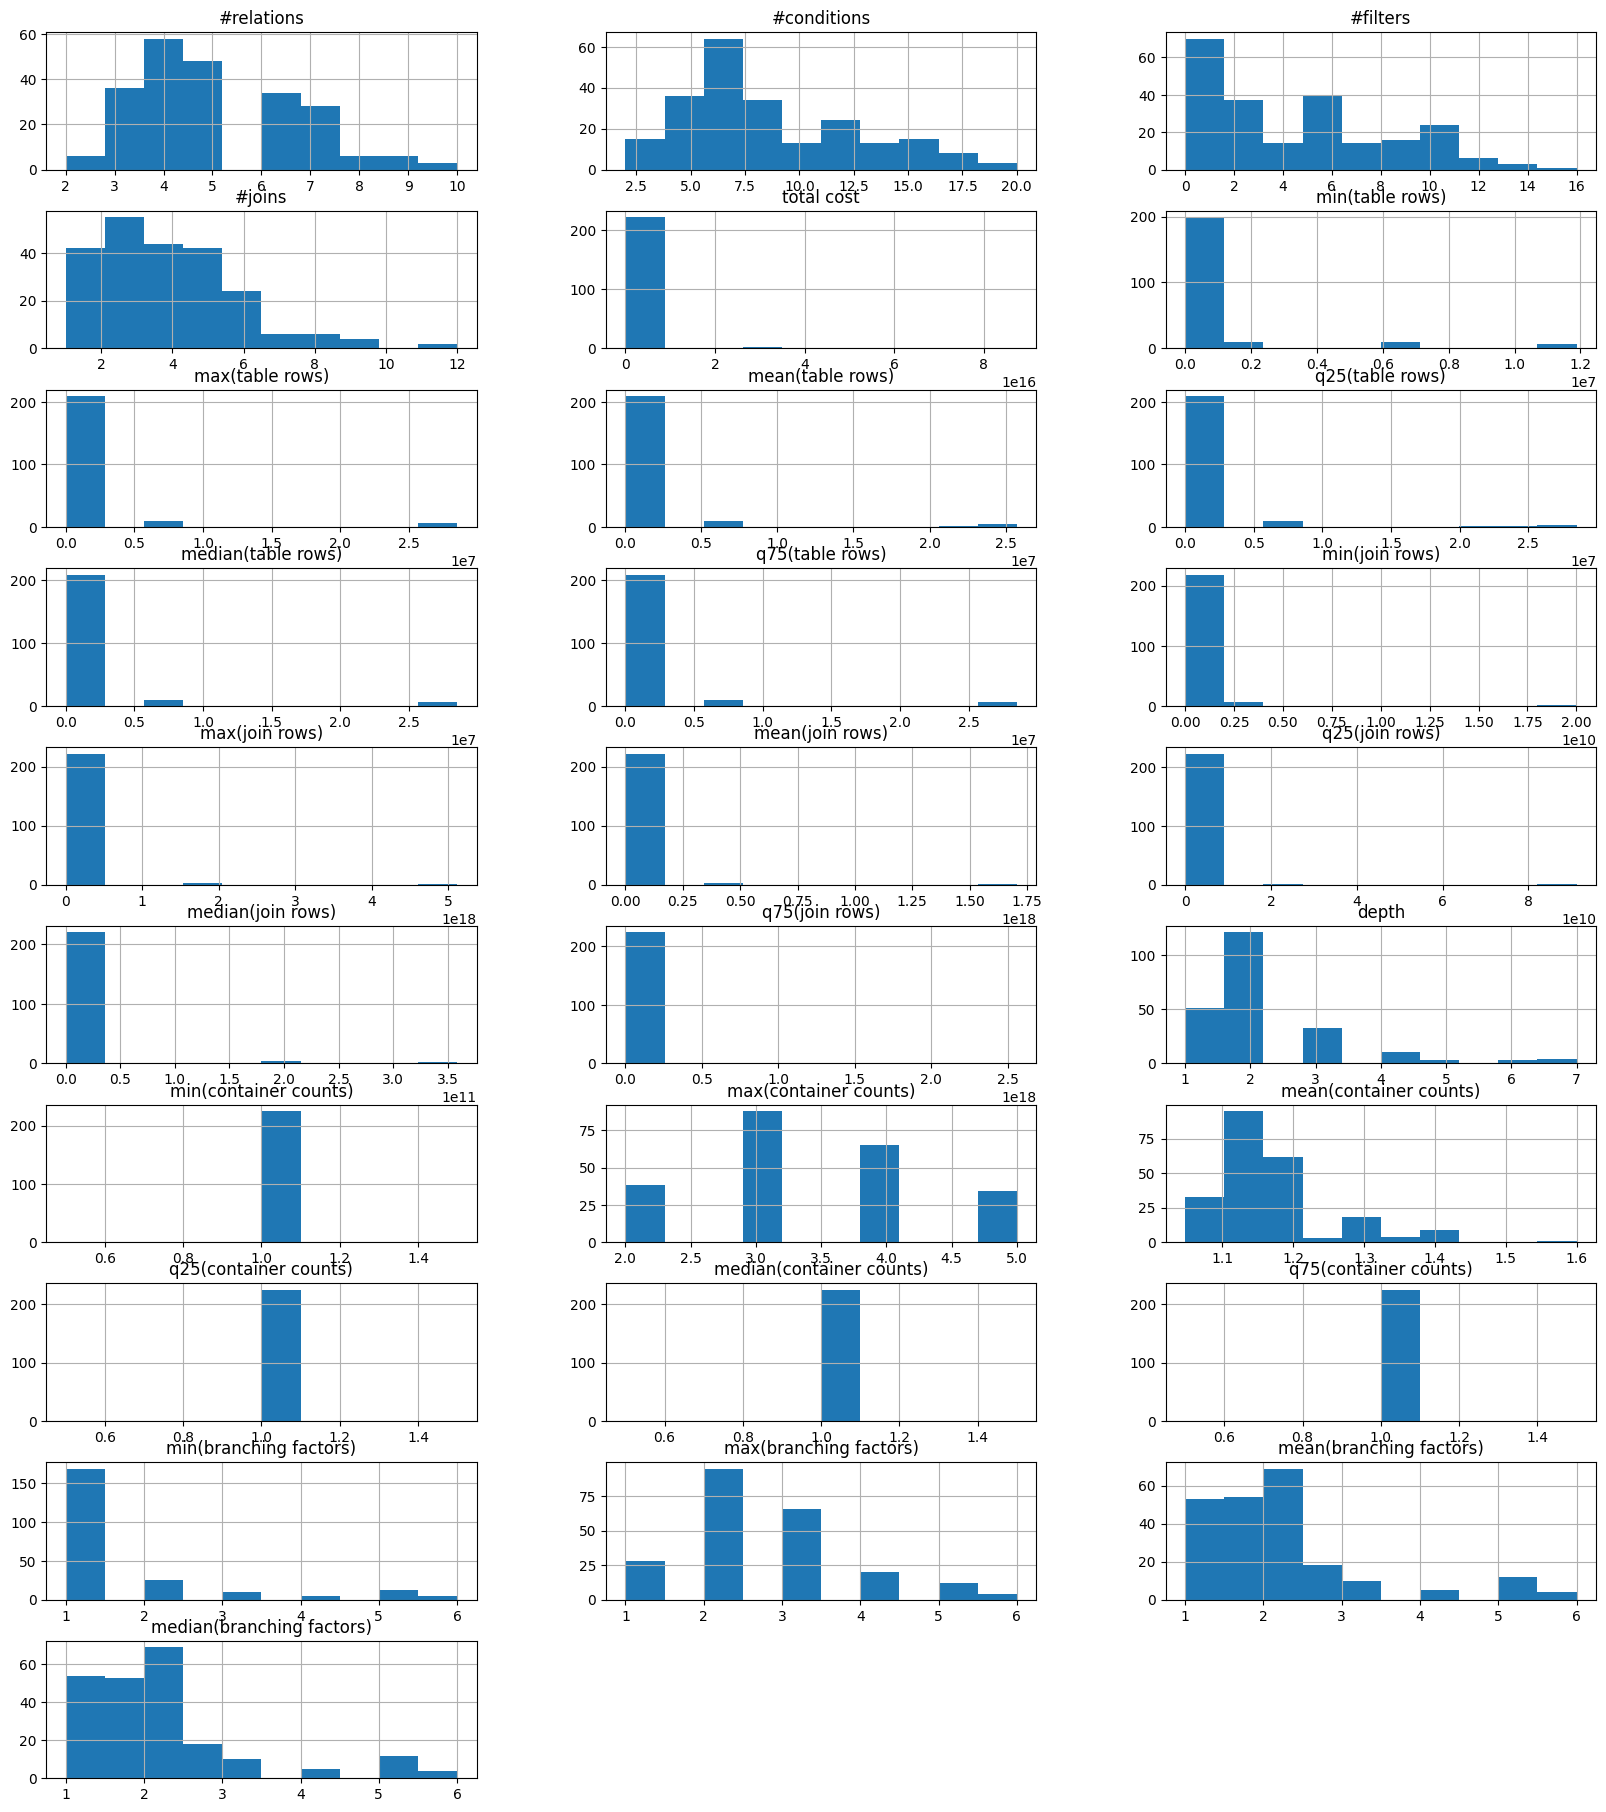

In [11]:
X.hist(layout=(11, 3), figsize=(20, 25))
plt.show()

We transform all table rows and join rows variables and the total cost.

In [12]:
columns_to_log = ['total cost', 'min(table rows)', 'max(table rows)',
       'mean(table rows)', 'q25(table rows)', 'median(table rows)',
       'q75(table rows)', 'min(join rows)', 'max(join rows)',
       'mean(join rows)', 'q25(join rows)', 'median(join rows)',
       'q75(join rows)']
X[columns_to_log] = X[columns_to_log].apply(np.log)

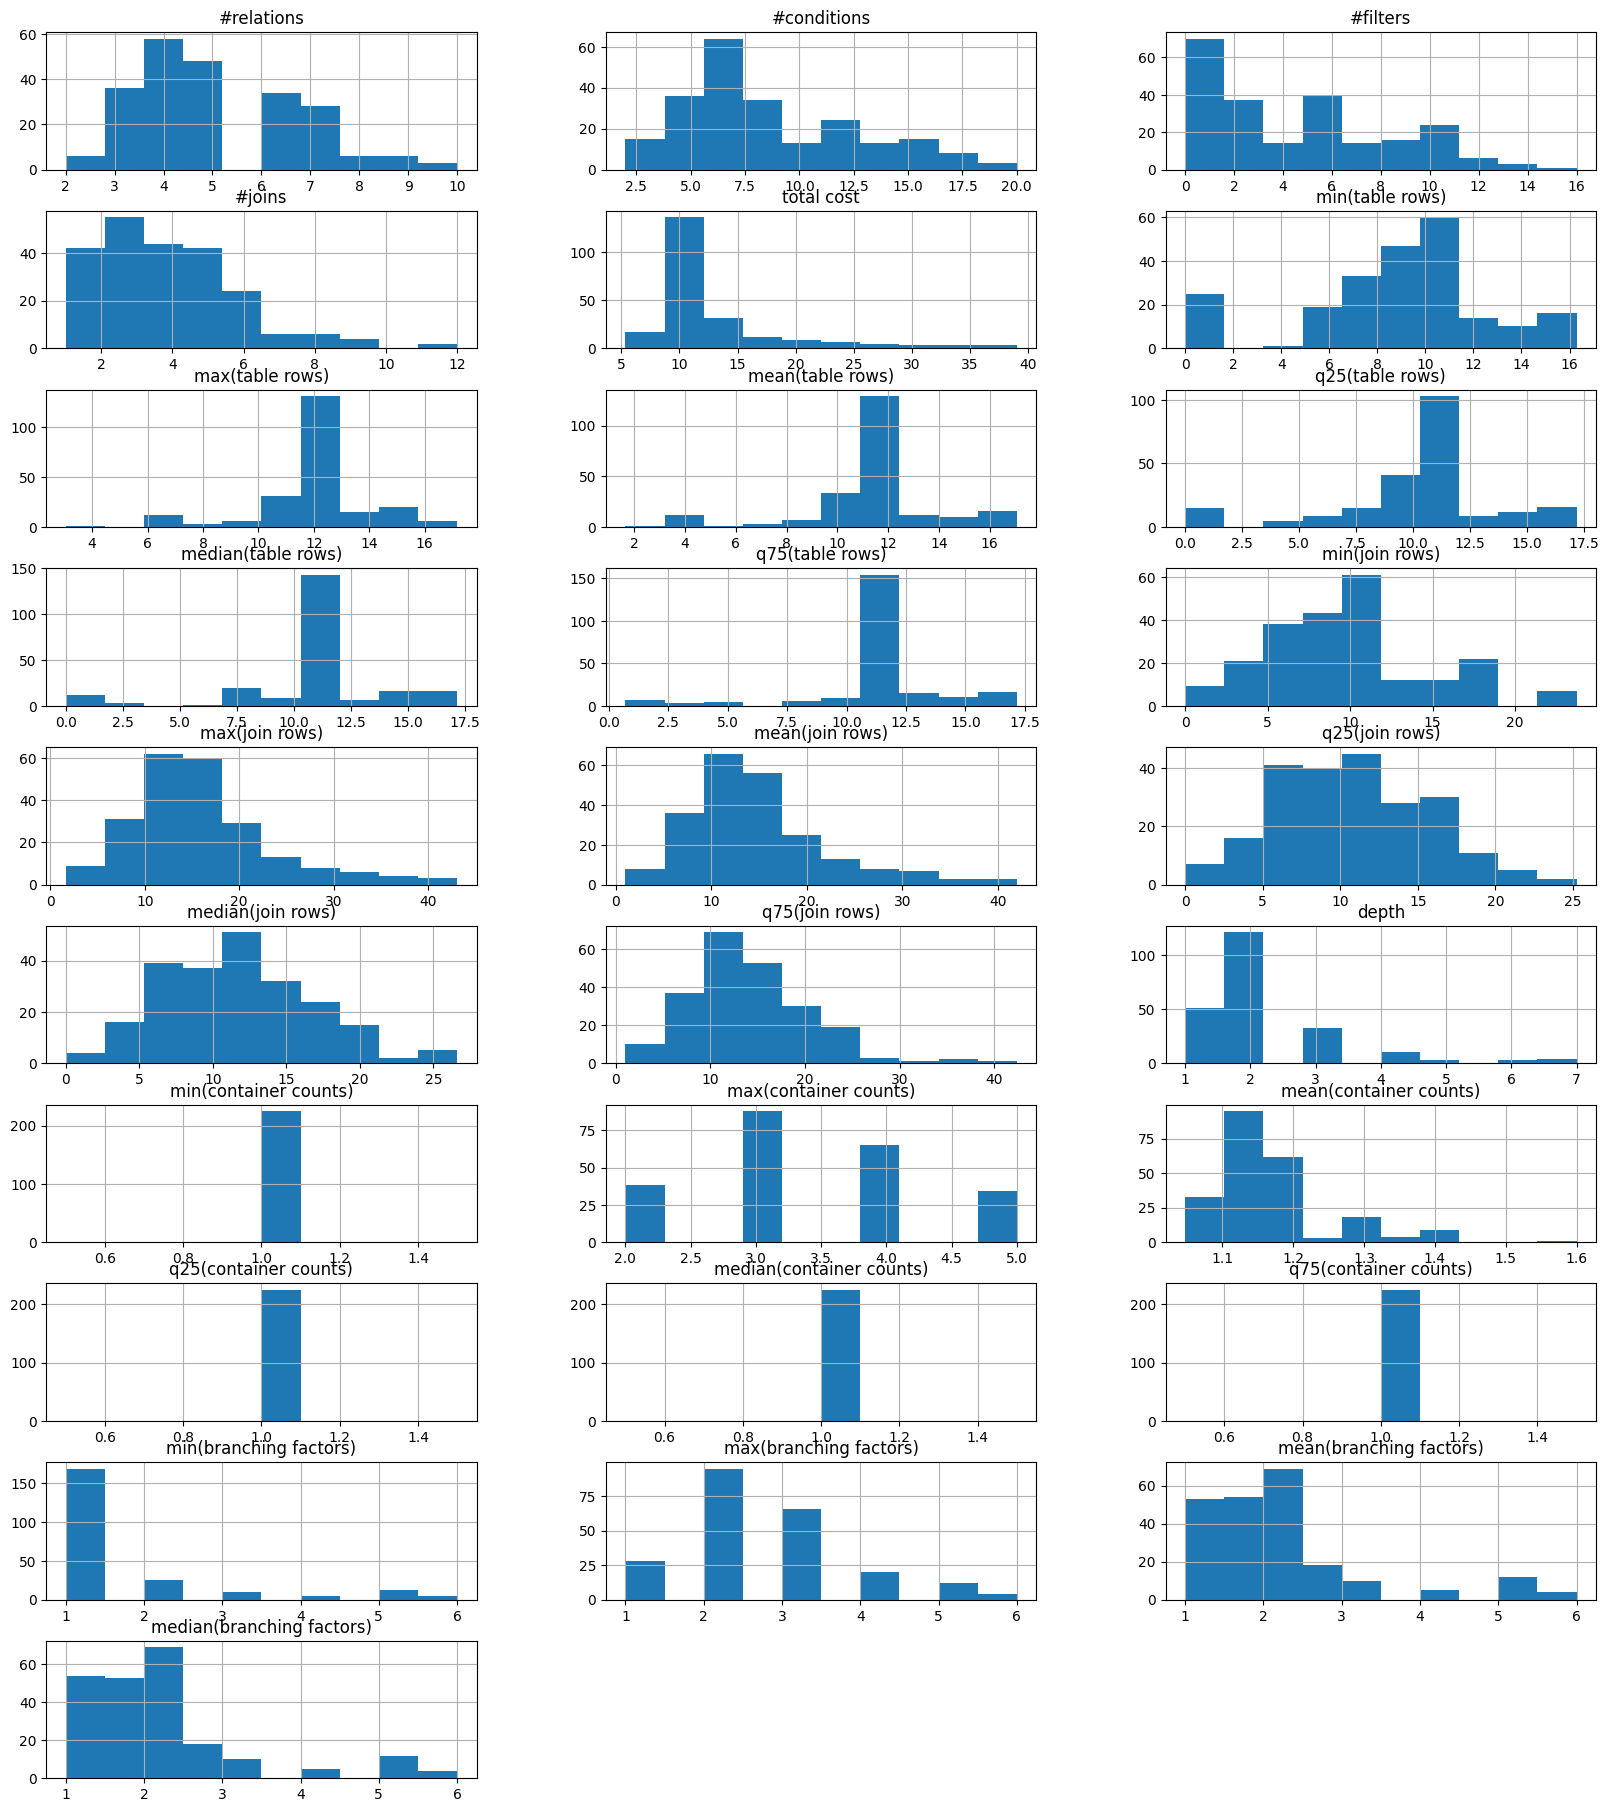

In [13]:
X.hist(layout=(11, 3), figsize=(20, 25))
plt.show()

#### Boxplots of running times for both cases (either original or rewritten)

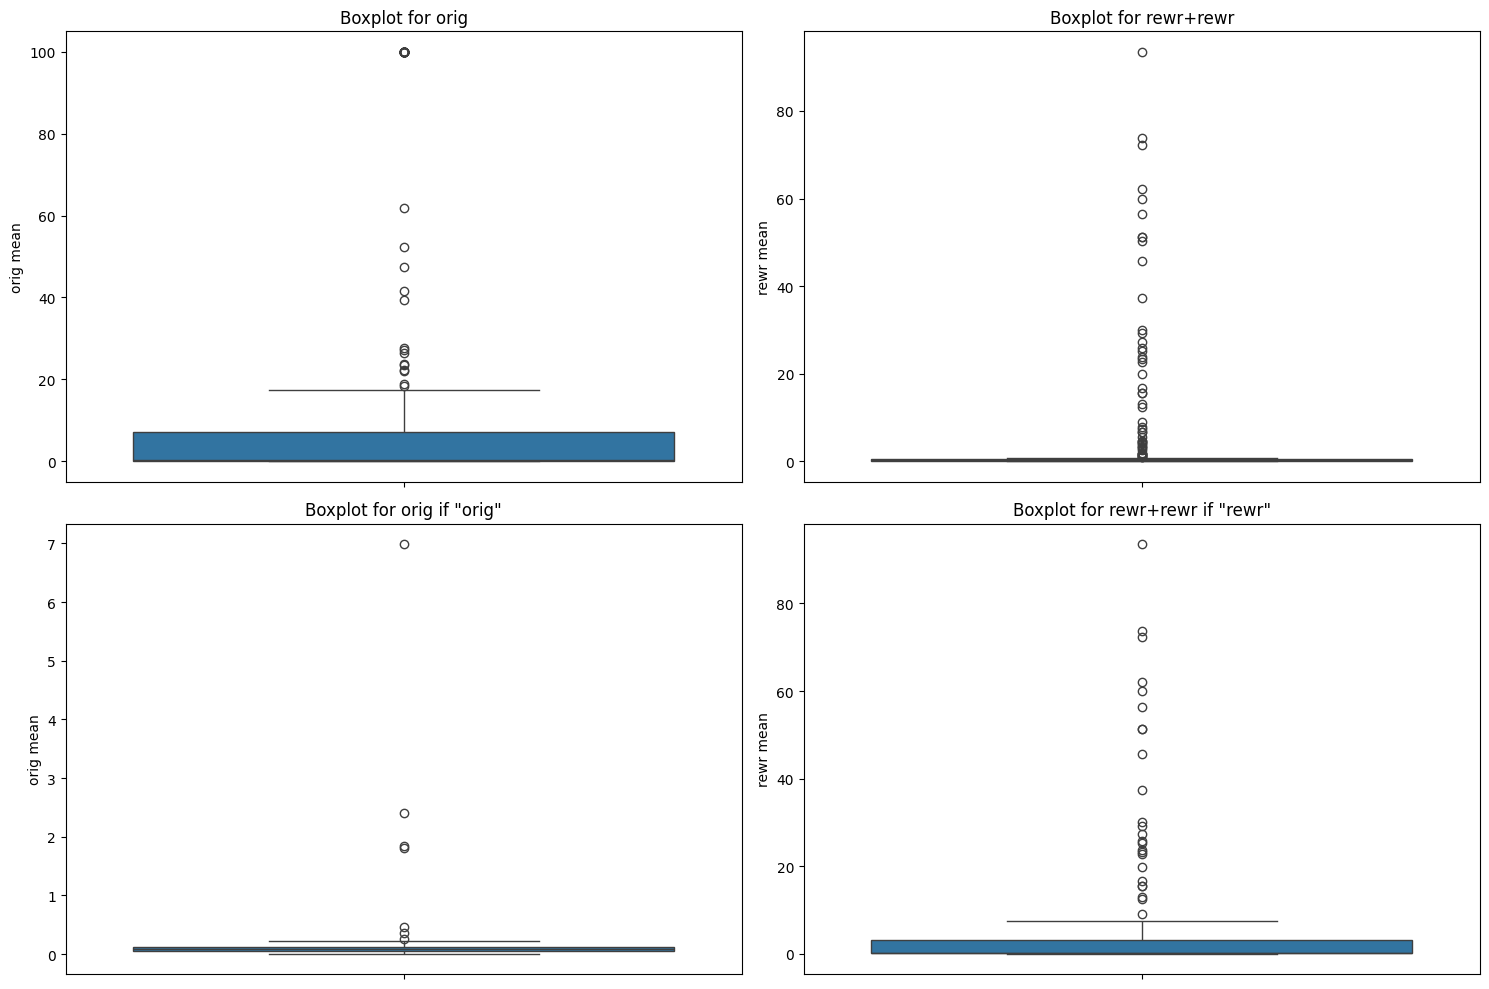

In [14]:
df_orig = df[df['orig/rewr(mean)'] == 'orig']
df_rewr = df[df['orig/rewr(mean)'] == 'rewr']

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

sns.boxplot(y='orig mean', data=df, ax=axes[0,0])
axes[0,0].set_title(f'Boxplot for orig')

sns.boxplot(y='rewr mean', data=df, ax=axes[0,1])
axes[0,1].set_title(f'Boxplot for rewr+rewr')

sns.boxplot(y='orig mean', data=df_orig, ax=axes[1,0])
axes[1,0].set_title(f'Boxplot for orig if "orig"')

sns.boxplot(y='rewr mean', data=df_rewr, ax=axes[1,1])
axes[1,1].set_title(f'Boxplot for rewr+rewr if "rewr"')

plt.tight_layout()
plt.show()

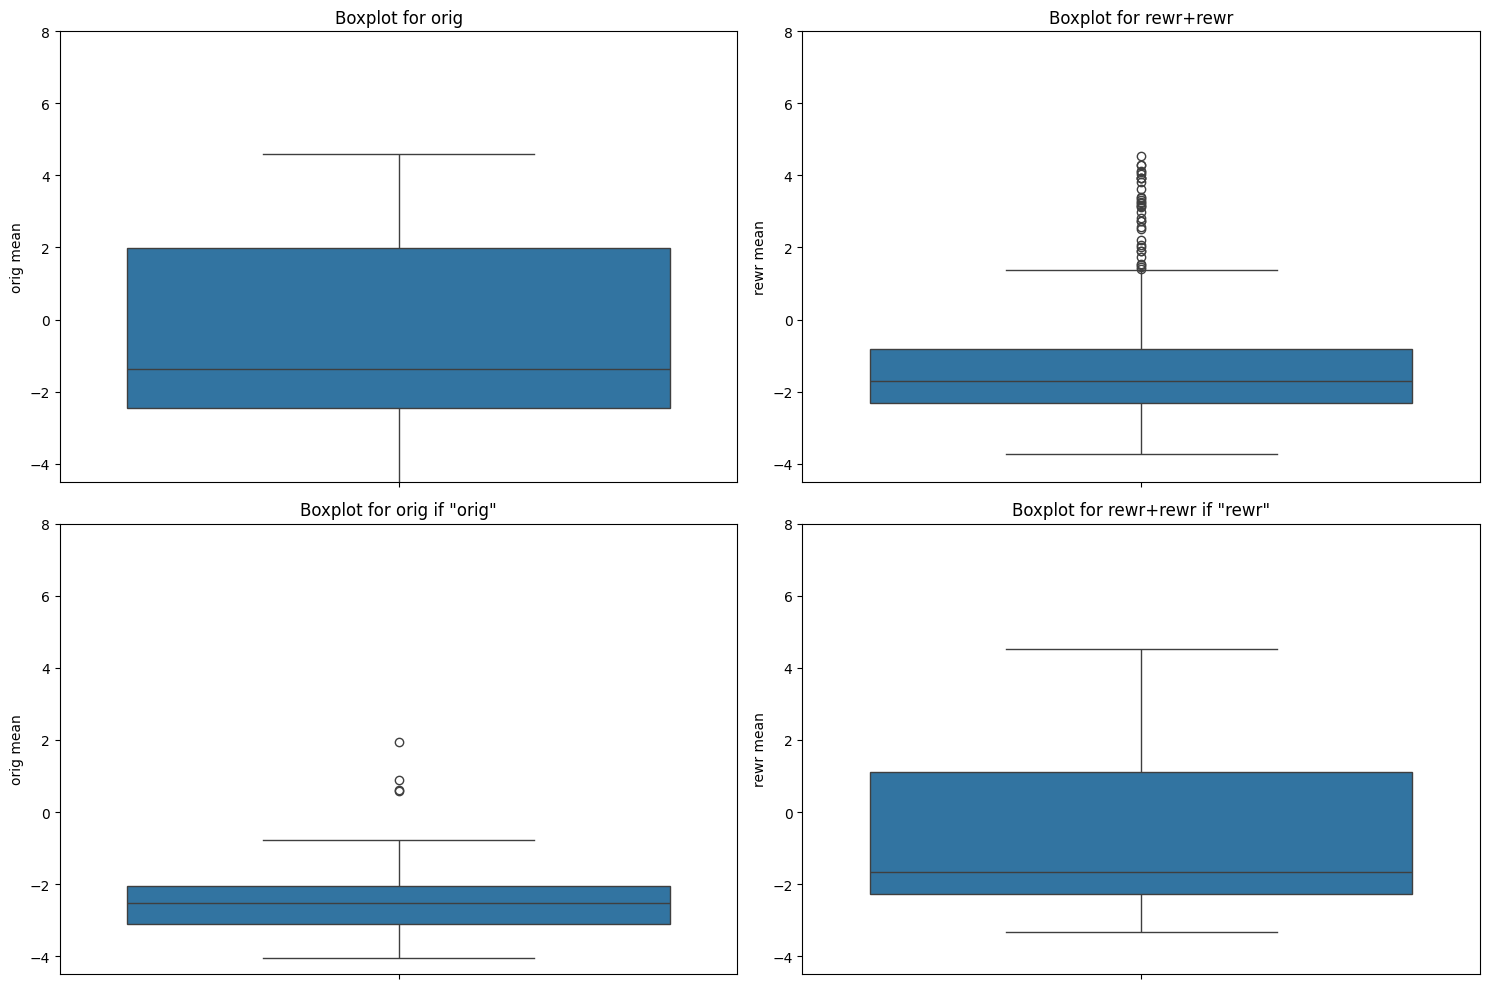

In [15]:
df_log = df.copy()
df_log["orig mean"] = np.log(df_log["orig mean"])
df_log["rewr mean"] = np.log(df_log["rewr mean"])

df_orig = df_log[df_log['orig/rewr(mean)'] == 'orig']
df_rewr = df_log[df_log['orig/rewr(mean)'] == 'rewr']

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

sns.boxplot(y='orig mean', data=df_log, ax=axes[0,0])
axes[0,0].set_title(f'Boxplot for orig')
axes[0,0].set_ylim(-4.5, 8) 

sns.boxplot(y='rewr mean', data=df_log, ax=axes[0,1])
axes[0,1].set_title(f'Boxplot for rewr+rewr')
axes[0,1].set_ylim(-4.5, 8) 

sns.boxplot(y='orig mean', data=df_orig, ax=axes[1,0])
axes[1,0].set_title(f'Boxplot for orig if "orig"')
axes[1,0].set_ylim(-4.5, 8) 

sns.boxplot(y='rewr mean', data=df_rewr, ax=axes[1,1])
axes[1,1].set_title(f'Boxplot for rewr+rewr if "rewr"')
axes[1,1].set_ylim(-4.5, 8) 

plt.tight_layout()
plt.show()

#### Scatterplot of running times

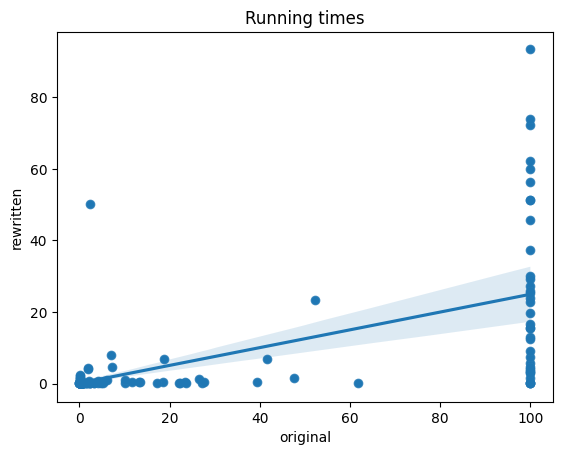

In [16]:
sns.scatterplot(x="orig mean", y="rewr mean", data=df)
sns.regplot(x="orig mean", y="rewr mean", data=df) 

plt.xlabel("original")
plt.ylabel("rewritten")
plt.title(f'Running times')

plt.show()

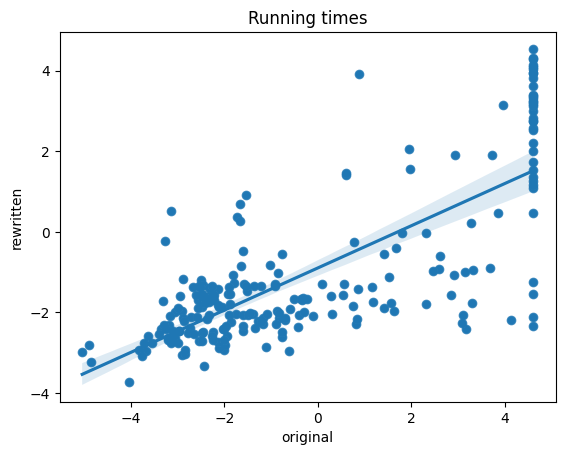

In [17]:
sns.scatterplot(x="orig mean", y="rewr mean", data=df_log)
sns.regplot(x="orig mean", y="rewr mean", data=df_log) 

plt.xlabel("original")
plt.ylabel("rewritten")
plt.title(f'Running times')

plt.show()

#### Classification response

Get the column(s) where we have "orig" or "rewr", depending on which method was faster. We now want to encode this as 0 (evaluating the original query faster) and 1 (evaluating the rewritten query faster).

In [18]:
mapping = {'orig': 0, 'rewr': 1}
y1 = df['orig/rewr(mean)'].map(mapping)
y1.head()

0     0
9     0
24    0
42    0
54    0
Name: orig/rewr(mean), dtype: int64

The number of appearances of original and rewritten is very balanced.

In [19]:
y1.value_counts()

orig/rewr(mean)
1    135
0     90
Name: count, dtype: int64

#### Classification response with three cases

In [20]:
condition = abs(df["diff rewr-orig"]) < 0.1
df["orig/rewr/equal 0.1"] = df["orig/rewr(mean)"]
df.loc[condition, 'orig/rewr/equal 0.1'] = 'equal'

/tmp/ipykernel_4526/1156232483.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["orig/rewr/equal 0.1"] = df["orig/rewr(mean)"]


In [21]:
condition = abs(df["diff rewr-orig"]) < 0.05
df["orig/rewr/equal 0.05"] = df["orig/rewr(mean)"]
df.loc[condition, 'orig/rewr/equal 0.05'] = 'equal'

/tmp/ipykernel_4526/833572260.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["orig/rewr/equal 0.05"] = df["orig/rewr(mean)"]


In [22]:
condition = abs(df["diff rewr-orig"]) < 0.01
df["orig/rewr/equal 0.01"] = df["orig/rewr(mean)"]
df.loc[condition, 'orig/rewr/equal 0.01'] = 'equal'

/tmp/ipykernel_4526/3661961662.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["orig/rewr/equal 0.01"] = df["orig/rewr(mean)"]


In [23]:
df.head(20)

,bench,query,orig/rewr(mean),orig/rewr+rewr(mean),orig mean,rewr mean,rewr mean+rewr,diff rewr-orig,diff rewr+rewr-orig,#relations,...,median(branching factors),balancedness factor,list table rows,list join rows,container counts list,branching factors list,text,orig/rewr/equal 0.1,orig/rewr/equal 0.05,orig/rewr/equal 0.01
0,STATS,001-014,orig,orig,0.025373,0.051895,1.977303,0.026522,1.951929,3,...,2.0,1.0,"[99733, 969, 31480]","[24066, 81]","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3]",[2],"SELECT MIN(u.Id) FROM comments as c, votes as ...",equal,equal,orig
9,STATS,002-048,orig,orig,0.066407,0.119431,1.928187,0.053025,1.861780,5,...,2.0,1.0,"[101755, 192979, 268, 31527, 79851]","[81277596, 98639, 10171, 194]","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[3, 1]","SELECT MIN(c.Id) FROM comments as c, postHisto...",equal,orig,orig
24,STATS,003-067,orig,orig,0.046820,0.137277,2.032372,0.090457,1.985552,6,...,5.0,1.0,"[192979, 78165, 25426, 10013, 1334, 38465]","[3421, 55, 58, 40, 145]","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",[5],"SELECT MIN(c.Id) FROM comments as c, posts as ...",equal,orig,orig
42,STATS,004-041,orig,orig,0.021953,0.053818,1.782038,0.031865,1.760085,4,...,1.5,1.0,"[79668, 10726, 771, 36453]","[158, 80, 90]","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[2, 1]","SELECT MIN(pl.Id) FROM postLinks as pl, posts ...",equal,equal,orig
54,STATS,005-024,orig,orig,0.023235,0.045902,1.994790,0.022667,1.971555,3,...,2.0,1.0,"[79851, 728, 39595]","[305, 76]","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3]",[2],"SELECT MIN(v.Id) FROM votes as v, badges as b,...",equal,equal,orig
63,STATS,006-054,orig,orig,0.028673,0.063050,2.082378,0.034377,2.053704,5,...,2.0,1.0,"[174305, 79851, 9751, 1560, 38375]","[1410, 307, 155, 165]","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[3, 1]","SELECT MIN(c.Id) FROM comments as c, postLinks...",equal,equal,orig
78,STATS,007-057,orig,orig,0.097585,0.125862,3.988339,0.028278,3.890755,5,...,2.0,1.0,"[91976, 79763, 1005, 39866, 1032]","[6, 799, 356, 106]","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[3, 1]","SELECT MIN(t.Id) FROM tags as t, posts as p, u...",equal,equal,orig
93,STATS,008-045,orig,orig,0.034703,0.089214,1.072889,0.054511,1.038186,4,...,1.5,1.0,"[53706, 192979, 78901, 889]","[87365, 886, 1739]","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[2, 1]","SELECT MIN(ph.Id) FROM postHistory as ph, vote...",equal,orig,orig
105,STATS,009-033,orig,orig,0.033511,0.079258,1.982533,0.045747,1.949022,4,...,1.5,1.0,"[102532, 178345, 1006, 29640]","[2451196, 2952, 79]","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[2, 1]","SELECT MIN(c.Id) FROM comments as c, postHisto...",equal,equal,orig
117,STATS,010-063,orig,orig,0.041796,0.099195,2.190270,0.057399,2.148474,6,...,2.5,1.0,"[79851, 78950, 966, 9834, 42261, 35899]","[3693, 61, 42, 48, 4519]","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[4, 1]","SELECT MIN(c.Id) FROM comments as c, posts as ...",equal,orig,orig


In [24]:
df["orig/rewr/equal 0.1"].value_counts()

orig/rewr/equal 0.1
rewr     108
equal     82
orig      35
Name: count, dtype: int64

In [25]:
df["orig/rewr/equal 0.05"].value_counts()

orig/rewr/equal 0.05
rewr     119
orig      59
equal     47
Name: count, dtype: int64

In [26]:
df["orig/rewr/equal 0.01"].value_counts()

orig/rewr/equal 0.01
rewr     131
orig      86
equal      8
Name: count, dtype: int64

In [27]:
mapping1 = {'orig': -1, 'rewr': 1, 'equal': 0}
y1_equal_01 = df['orig/rewr/equal 0.1'].map(mapping1)
y1_equal_01.head()

0     0
9     0
24    0
42    0
54    0
Name: orig/rewr/equal 0.1, dtype: int64

In [28]:
mapping1 = {'orig': -1, 'rewr': 1, 'equal': 0}
y1_equal_005 = df['orig/rewr/equal 0.05'].map(mapping1)
y1_equal_005.head()

0     0
9    -1
24   -1
42    0
54    0
Name: orig/rewr/equal 0.05, dtype: int64

In [29]:
mapping1 = {'orig': -1, 'rewr': 1, 'equal': 0}
y1_equal_001 = df['orig/rewr/equal 0.01'].map(mapping1)
y1_equal_001.head()

0    -1
9    -1
24   -1
42   -1
54   -1
Name: orig/rewr/equal 0.01, dtype: int64

#### Regression response

We also have the time differences between the original and rewritten method and we want to use that as numerical response.

In [30]:
y1_diff = df["diff rewr-orig"]
#y1_diff = df["diff rewr+rewr-orig"]

We can see that the time difference has a wide range of values (or is skewed).

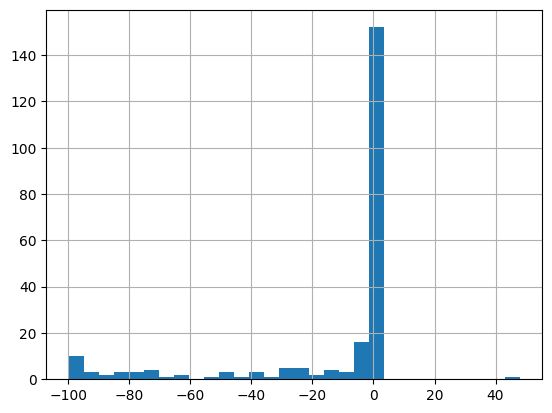

In [31]:
y1_diff.hist(bins = 30)
plt.show()

Therefore, we are going to transform it. As before with the features, we would like to apply a log transformation. Neverthless, since we have negative values this cannot be applied directly. We are going to multiple to log of the absolute values with the sign they had before. Additionally, since we have a lot of values close to zero, which leads to very low log values, we add 1 to the absolute values, which is a common method.   
$x = sgn(x) * log(|x| + 1)$

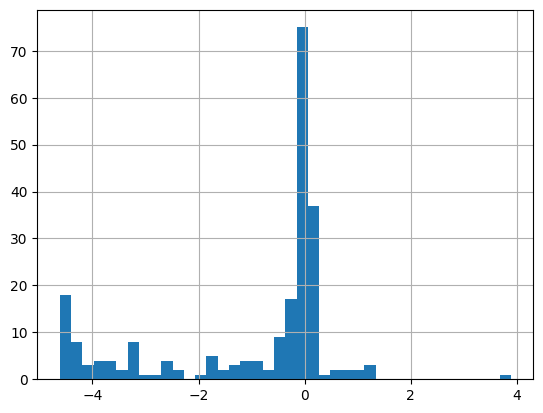

In [32]:
y1_diff_log = np.sign(y1_diff) * np.log(abs(y1_diff) +1)
y1_diff_log.hist(bins = 40)
plt.show()

#### Train-validation-test split

We split the dataset such that each benchmark dataset is represented in the train and in the test set (stratification). We do a 80% train, 10% validation and 10% test split.

In [33]:
X_train, X_test1, y1_train, y1_test1 = train_test_split(X, y1, test_size=0.2, stratify=df["bench"], random_state=20)

In [34]:
index_df = df.loc[X_test1.index]["bench"]
index = index_df[index_df == "LSQB"].index
strat_df = df.loc[X_test1.index]["bench"].drop(index)
X_test = X_test1.drop(index)
y1_test = y1_test1.drop(index)

In [35]:
X_val, X_test, y1_val, y1_test = train_test_split(X_test, y1_test, test_size=0.5, stratify=strat_df, random_state=20)

In [36]:
X_val.loc[index[0]] = X_test1.loc[index[0]]
y1_val.loc[index[0]] = y1_test1.loc[index[0]]

In [37]:
y1_diff_log_train = y1_diff_log.loc[y1_train.index]
y1_diff_log_val = y1_diff_log.loc[y1_val.index]
y1_diff_log_test = y1_diff_log.loc[y1_test.index]
y1_equal_005_train = y1_equal_005.loc[y1_train.index]
y1_equal_005_val = y1_equal_005.loc[y1_val.index]
y1_equal_005_test = y1_equal_005.loc[y1_test.index]
y1_equal_01_train = y1_equal_01.loc[y1_train.index]
y1_equal_01_val = y1_equal_01.loc[y1_val.index]
y1_equal_01_test = y1_equal_01.loc[y1_test.index]
y1_equal_001_train = y1_equal_001.loc[y1_train.index]
y1_equal_001_val = y1_equal_001.loc[y1_val.index]
y1_equal_001_test = y1_equal_001.loc[y1_test.index]

## ML models

### Decision tree with two classes

In [38]:
clf = DecisionTreeClassifier(random_state = 20)
clf.fit(X_train, y1_train)
y1_pred_dec_tree = clf.predict(X_val)

In [39]:
accuracy = accuracy_score(y1_val, y1_pred_dec_tree)
accuracy

0.782608695652174

In [40]:
conf_matrix = confusion_matrix(y1_val, y1_pred_dec_tree)
conf_matrix

array([[10,  3],
       [ 2,  8]])

### Decision tree with three classes

##### equal cut off: 0.05

In [41]:
clf = DecisionTreeClassifier(random_state = 20)
clf.fit(X_train, y1_equal_005_train)
y1_equal_005_pred_dec_tree = clf.predict(X_val)

In [42]:
accuracy = accuracy_score(y1_equal_005_val, y1_equal_005_pred_dec_tree)
accuracy

0.5652173913043478

In [43]:
conf_matrix = confusion_matrix(y1_equal_005_val, y1_equal_005_pred_dec_tree)
conf_matrix

array([[5, 3, 2],
       [2, 0, 1],
       [2, 0, 8]])

##### equal cut off: 0.1

In [44]:
clf = DecisionTreeClassifier(random_state = 20)
clf.fit(X_train, y1_equal_01_train)
y1_equal_01_pred_dec_tree = clf.predict(X_val)

In [45]:
accuracy = accuracy_score(y1_equal_01_val, y1_equal_01_pred_dec_tree)
accuracy

0.6956521739130435

In [46]:
conf_matrix = confusion_matrix(y1_equal_01_val, y1_equal_01_pred_dec_tree)
conf_matrix

array([[3, 0, 2],
       [1, 7, 2],
       [0, 2, 6]])

##### equal cut off: 0.01

In [47]:
clf = DecisionTreeClassifier(random_state = 20)
clf.fit(X_train, y1_equal_001_train)
y1_equal_001_pred_dec_tree = clf.predict(X_val)

In [48]:
accuracy = accuracy_score(y1_equal_001_val, y1_equal_001_pred_dec_tree)
accuracy

0.782608695652174

In [49]:
conf_matrix = confusion_matrix(y1_equal_001_val, y1_equal_001_pred_dec_tree)
conf_matrix

array([[10,  0,  2],
       [ 1,  0,  0],
       [ 2,  0,  8]])

### Decision tree with time difference

In [50]:
model = DecisionTreeRegressor(random_state = 20)
model.fit(X_train, y1_diff_log_train)
y1_pred_dec_tree = model.predict(X_val)

In [51]:
mse = mean_squared_error(y1_diff_log_val, y1_pred_dec_tree)
mse

0.1650543481654887

### Random Forest with two classes

In [52]:
model = RandomForestClassifier(n_estimators=100, random_state=20)
model.fit(X_train, y1_train)
y1_pred_rand_forest = model.predict(X_val)

In [53]:
accuracy = accuracy_score(y1_val, y1_pred_rand_forest)
accuracy

0.782608695652174

In [54]:
conf_matrix = confusion_matrix(y1_val, y1_pred_rand_forest)
conf_matrix

array([[9, 4],
       [1, 9]])

### Random Forest with three classes

In [55]:
model = RandomForestClassifier(n_estimators=100, random_state=20)
model.fit(X_train, y1_equal_005_train)
y1_pred_rand_forest = model.predict(X_val)

In [56]:
accuracy = accuracy_score(y1_equal_005_val, y1_pred_rand_forest)
accuracy

0.6956521739130435

In [57]:
conf_matrix = confusion_matrix(y1_equal_005_val, y1_pred_rand_forest)
conf_matrix

array([[7, 1, 2],
       [2, 0, 1],
       [1, 0, 9]])

In [58]:
model = RandomForestClassifier(n_estimators=100, random_state=20)
model.fit(X_train, y1_equal_001_train)
y1_pred_rand_forest = model.predict(X_val)

In [59]:
accuracy = accuracy_score(y1_equal_001_val, y1_pred_rand_forest)
accuracy

0.782608695652174

In [60]:
conf_matrix = confusion_matrix(y1_equal_001_val, y1_pred_rand_forest)
conf_matrix

array([[9, 0, 3],
       [1, 0, 0],
       [1, 0, 9]])

### Random Forest with time difference

In [61]:
model = RandomForestRegressor(n_estimators=100, random_state=20)
model.fit(X_train, y1_diff_log_train)
y1_pred_rand_forest = model.predict(X_val)

In [62]:
mse = mean_squared_error(y1_diff_log_val, y1_pred_rand_forest)
mse

0.629562434412612

### SVM (Support Vector Machine) with two classes

In [63]:
clf = SVC(kernel='linear')
clf.fit(X_train, y1_train)
y1_pred_svm_linear = clf.predict(X_val)

In [64]:
accuracy = accuracy_score(y1_val, y1_pred_svm_linear)
accuracy

0.7391304347826086

In [65]:
conf_matrix = confusion_matrix(y1_val, y1_pred_svm_linear)
conf_matrix

array([[8, 5],
       [1, 9]])

In [66]:
clf = SVC(kernel='poly')
clf.fit(X_train, y1_train)
y1_pred_svm_poly = clf.predict(X_val)

In [67]:
accuracy = accuracy_score(y1_val, y1_pred_svm_poly)
accuracy

0.782608695652174

In [68]:
conf_matrix = confusion_matrix(y1_val, y1_pred_svm_poly)
conf_matrix

array([[10,  3],
       [ 2,  8]])

In [69]:
clf = SVC(kernel='rbf')
clf.fit(X_train, y1_train)
y1_pred_svm_rbf = clf.predict(X_val)

In [70]:
accuracy = accuracy_score(y1_val, y1_pred_svm_rbf)
accuracy

0.7391304347826086

In [71]:
conf_matrix = confusion_matrix(y1_val, y1_pred_svm_rbf)
conf_matrix

array([[9, 4],
       [2, 8]])

### SVM (Support Vector Machine) with three classes

In [72]:
clf = SVC(kernel='linear')
clf.fit(X_train, y1_equal_005_train)
y1_pred_svm_linear = clf.predict(X_val)

In [73]:
accuracy = accuracy_score(y1_equal_005_val, y1_pred_svm_linear)
accuracy

0.6521739130434783

In [74]:
conf_matrix = confusion_matrix(y1_equal_005_val, y1_pred_svm_linear)
conf_matrix

array([[4, 2, 4],
       [1, 2, 0],
       [1, 0, 9]])

In [75]:
clf = SVC(kernel='poly')
clf.fit(X_train, y1_equal_005_train)
y1_pred_svm_poly = clf.predict(X_val)

In [76]:
accuracy = accuracy_score(y1_equal_005_val, y1_pred_svm_poly)
accuracy

0.6956521739130435

In [77]:
conf_matrix = confusion_matrix(y1_equal_005_val, y1_pred_svm_poly)
conf_matrix

array([[8, 1, 1],
       [1, 0, 2],
       [2, 0, 8]])

In [78]:
clf = SVC(kernel='rbf')
clf.fit(X_train, y1_equal_005_train)
y1_pred_svm_rbf = clf.predict(X_val)

In [79]:
accuracy = accuracy_score(y1_equal_005_val, y1_pred_svm_rbf)
accuracy

0.6956521739130435

In [80]:
conf_matrix = confusion_matrix(y1_equal_005_val, y1_pred_svm_rbf)
conf_matrix

array([[8, 0, 2],
       [1, 0, 2],
       [2, 0, 8]])

In [81]:
clf = SVC(kernel='linear')
clf.fit(X_train, y1_equal_001_train)
y1_pred_svm_linear = clf.predict(X_val)

In [82]:
accuracy = accuracy_score(y1_equal_001_val, y1_pred_svm_linear)
accuracy

0.782608695652174

In [83]:
conf_matrix = confusion_matrix(y1_equal_001_val, y1_pred_svm_linear)
conf_matrix

array([[9, 1, 2],
       [1, 0, 0],
       [1, 0, 9]])

In [84]:
clf = SVC(kernel='poly')
clf.fit(X_train, y1_equal_001_train)
y1_pred_svm_poly = clf.predict(X_val)

In [85]:
accuracy = accuracy_score(y1_equal_001_val, y1_pred_svm_poly)
accuracy

0.782608695652174

In [86]:
conf_matrix = confusion_matrix(y1_equal_001_val, y1_pred_svm_poly)
conf_matrix

array([[10,  0,  2],
       [ 0,  0,  1],
       [ 2,  0,  8]])

In [87]:
clf = SVC(kernel='rbf')
clf.fit(X_train, y1_equal_001_train)
y1_pred_svm_rbf = clf.predict(X_val)

In [88]:
accuracy = accuracy_score(y1_equal_001_val, y1_pred_svm_rbf)
accuracy

0.7391304347826086

In [89]:
conf_matrix = confusion_matrix(y1_equal_001_val, y1_pred_svm_rbf)
conf_matrix

array([[9, 0, 3],
       [0, 0, 1],
       [2, 0, 8]])

### SVM (Support Vector Machine) with time difference

In [90]:
clf = SVR(kernel='linear')
clf.fit(X_train, y1_diff_log_train)
y1_pred_svm_linear = clf.predict(X_val)

In [91]:
mse = mean_squared_error(y1_diff_log_val, y1_pred_svm_linear)
mse

0.9384284018323494

In [92]:
clf = SVR(kernel='poly')
clf.fit(X_train, y1_diff_log_train)
y1_pred_svm_poly = clf.predict(X_val)

In [93]:
mse = mean_squared_error(y1_diff_log_val, y1_pred_svm_poly)
mse

4.842667581049725

In [94]:
clf = SVR(kernel='rbf')
clf.fit(X_train, y1_diff_log_train)
y1_pred_svm_rbf = clf.predict(X_val)

In [95]:
mse = mean_squared_error(y1_diff_log_val, y1_pred_svm_rbf)
mse

0.9884317901558485

### kNN with two classes

In [96]:
clf = KNeighborsClassifier(n_neighbors=5) 
clf.fit(X_train, y1_train)
y1_pred_kNN_5 = clf.predict(X_val)

In [97]:
accuracy = accuracy_score(y1_val, y1_pred_kNN_5)
accuracy

0.6956521739130435

In [98]:
conf_matrix = confusion_matrix(y1_val, y1_pred_kNN_5)
conf_matrix

array([[8, 5],
       [2, 8]])

### kNN with three classes

In [99]:
clf = KNeighborsClassifier(n_neighbors=5) 
clf.fit(X_train, y1_equal_001_train)
y1_pred_kNN_5 = clf.predict(X_val)

In [100]:
accuracy = accuracy_score(y1_equal_001_val, y1_pred_kNN_5)
accuracy

0.6956521739130435

In [101]:
conf_matrix = confusion_matrix(y1_equal_001_val, y1_pred_kNN_5)
conf_matrix

array([[8, 0, 4],
       [1, 0, 0],
       [2, 0, 8]])

In [102]:
clf = KNeighborsClassifier(n_neighbors=5) 
clf.fit(X_train, y1_equal_005_train)
y1_pred_kNN_5 = clf.predict(X_val)

In [103]:
accuracy = accuracy_score(y1_equal_005_val, y1_pred_kNN_5)
accuracy

0.6086956521739131

In [104]:
conf_matrix = confusion_matrix(y1_equal_005_val, y1_pred_kNN_5)
conf_matrix

array([[6, 1, 3],
       [2, 0, 1],
       [2, 0, 8]])

### kNN with time difference

In [105]:
clf = KNeighborsRegressor(n_neighbors=5) 
clf.fit(X_train, y1_diff_log_train)
y1_pred_kNN_5 = clf.predict(X_val)

In [106]:
mse = mean_squared_error(y1_diff_log_val, y1_pred_kNN_5)
mse

0.4436404140463933

### Deep MLP with two classes

In [107]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, X, y):
        self.X = torch.from_numpy(X.values).float()  # Convert DataFrame to tensor
        self.y = torch.from_numpy(y.values).float()  # Convert DataFrame to tensor

    def __len__(self):
        return len(self.X)

    def __getitem__(self, index):
        return self.X[index], self.y[index]

In [108]:
class MLPClassifier(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(28, 40),
            nn.ReLU(),
            nn.Linear(40, 20),
            nn.ReLU(),
            nn.Linear(20, 2)
        )

    def forward(self, x):
        return self.layers(x)

In [109]:
custom_dataset = CustomDataset(X_train, y1_train)  # Assuming X_train and y_train are your training data
trainloader = DataLoader(custom_dataset, batch_size=10, shuffle=True)

In [110]:
mlp = MLPClassifier(random_seed=20)

# Define loss function and optimizer
loss_function = nn.CrossEntropyLoss()  # For multi-class classification, use CrossEntropyLoss
optimizer = torch.optim.Adagrad(mlp.parameters(), lr=0.01)

In [111]:
for epoch in range(200):
    print(f'Starting Epoch {epoch+1}')

    current_loss = 0.0

    for i, data in enumerate(trainloader, 0):
        inputs, targets = data

        optimizer.zero_grad()

        outputs = mlp(inputs)

        targets = targets.long()  # Convert target tensor to torch.long data type
        loss = loss_function(outputs, targets)

        loss.backward()

        optimizer.step()

        current_loss += loss.item()

    print(current_loss/len(trainloader))

print("Training has completed")

Starting Epoch 1
0.6251136660575867
Starting Epoch 2
0.5204014695352979
Starting Epoch 3
0.4865887297524346
Starting Epoch 4
0.4719503041770723
Starting Epoch 5
0.4633908064828979
Starting Epoch 6
0.47509828209877014
Starting Epoch 7
0.4466058545642429
Starting Epoch 8
0.4495912359820472
Starting Epoch 9
0.44171308974425
Starting Epoch 10
0.4375982975794209
Starting Epoch 11
0.4316827836963866
Starting Epoch 12
0.4216550596886211
Starting Epoch 13
0.4277590579456753
Starting Epoch 14
0.43419980423318016
Starting Epoch 15
0.42342210229900146
Starting Epoch 16
0.42801741262276966
Starting Epoch 17
0.4207625554667579
Starting Epoch 18
0.4259437339173423
Starting Epoch 19
0.41144755441281533
Starting Epoch 20
0.40944772130913204
Starting Epoch 21
0.4030907170640098
Starting Epoch 22
0.39978161868121886
Starting Epoch 23
0.41468390574057895
Starting Epoch 24
0.39938461283842724
Starting Epoch 25
0.39942829724815154
Starting Epoch 26
0.3955843200286229
Starting Epoch 27
0.39494720722238225
S

In [112]:
val_data = torch.tensor(X_val.values, dtype=torch.float32)
val_targets = torch.tensor(y1_val.values, dtype=torch.float32)

mlp.eval() 

with torch.no_grad():
    outputs = mlp(val_data)
    predicted_labels = torch.argmax(outputs, dim=1).numpy()

In [113]:
accuracy = accuracy_score(val_targets, predicted_labels)
accuracy

0.782608695652174

In [114]:
conf_matrix = confusion_matrix(val_targets, predicted_labels)
conf_matrix

array([[9, 4],
       [1, 9]])

### Deep MLP with three classes

In [115]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, X, y):
        self.X = torch.from_numpy(X.values).float()  # Convert DataFrame to tensor
        self.y = torch.from_numpy(y.values).float()  # Convert DataFrame to tensor

    def __len__(self):
        return len(self.X)

    def __getitem__(self, index):
        return self.X[index], self.y[index]

In [116]:
class MLPClassifier(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(28, 40),
            nn.ReLU(),
            nn.Linear(40, 20),
            nn.ReLU(),
            nn.Linear(20, 3)
        )

    def forward(self, x):
        return self.layers(x)

In [117]:
y1_equal_005_train_transformed = y1_equal_005_train + 1  # Transform -1 to 0, 0 to 1, and 1 to 2
y1_equal_005_val_transformed = y1_equal_005_val + 1

In [118]:
custom_dataset = CustomDataset(X_train, y1_equal_005_train_transformed)  # Assuming X_train and y_train are your training data
trainloader = DataLoader(custom_dataset, batch_size=10, shuffle=True)

In [119]:
mlp = MLPClassifier(random_seed=20)

# Define loss function and optimizer
loss_function = nn.CrossEntropyLoss()  # For multi-class classification, use CrossEntropyLoss
optimizer = torch.optim.Adagrad(mlp.parameters(), lr=0.01)

In [120]:
for epoch in range(200):
    print(f'Starting Epoch {epoch+1}')

    current_loss = 0.0

    for i, data in enumerate(trainloader, 0):
        inputs, targets = data

        optimizer.zero_grad()

        outputs = mlp(inputs)

        targets = targets.long()  # Convert target tensor to torch.long data type
        loss = loss_function(outputs, targets)

        loss.backward()

        optimizer.step()

        current_loss += loss.item()

    print(current_loss/len(trainloader))

print("Training has completed")

Starting Epoch 1
1.0478176044093237
Starting Epoch 2
0.8520038409365548
Starting Epoch 3
0.8012662513388528
Starting Epoch 4
0.7941822078492906
Starting Epoch 5
0.7608878148926629
Starting Epoch 6
0.7668645862076018
Starting Epoch 7
0.7671179241604276
Starting Epoch 8
0.7376058614916272
Starting Epoch 9
0.7385517888598971
Starting Epoch 10
0.7369605137242211
Starting Epoch 11
0.7275184045235316
Starting Epoch 12
0.7309063937928941
Starting Epoch 13
0.724068303902944
Starting Epoch 14
0.7166465669870377
Starting Epoch 15
0.7123510638872782
Starting Epoch 16
0.7042770948674943
Starting Epoch 17
0.7013116594817903
Starting Epoch 18
0.7039478917916616
Starting Epoch 19
0.7069921559757657
Starting Epoch 20
0.695554236570994
Starting Epoch 21
0.6939127908812629
Starting Epoch 22
0.6916417065593932
Starting Epoch 23
0.681677414311303
Starting Epoch 24
0.6639127135276794
Starting Epoch 25
0.6766940438085132
Starting Epoch 26
0.6838253339131674
Starting Epoch 27
0.6709611068169276
Starting Epoc

In [121]:
val_data = torch.tensor(X_val.values, dtype=torch.float32)
val_targets = torch.tensor(y1_equal_005_val_transformed.values, dtype=torch.float32)

mlp.eval() 

with torch.no_grad():
    outputs = mlp(val_data)
    predicted_labels = torch.argmax(outputs, dim=1).numpy()

In [122]:
accuracy = accuracy_score(val_targets, predicted_labels)
accuracy

0.6086956521739131

In [123]:
conf_matrix = confusion_matrix(val_targets, predicted_labels)
conf_matrix

array([[4, 1, 5],
       [1, 1, 1],
       [1, 0, 9]])

In [124]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, X, y):
        self.X = torch.from_numpy(X.values).float()  # Convert DataFrame to tensor
        self.y = torch.from_numpy(y.values).float()  # Convert DataFrame to tensor

    def __len__(self):
        return len(self.X)

    def __getitem__(self, index):
        return self.X[index], self.y[index]

In [125]:
class MLPClassifier(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(28, 40),
            nn.ReLU(),
            nn.Linear(40, 20),
            nn.ReLU(),
            nn.Linear(20, 3)
        )

    def forward(self, x):
        return self.layers(x)

In [126]:
y1_equal_001_train_transformed = y1_equal_001_train + 1  # Transform -1 to 0, 0 to 1, and 1 to 2
y1_equal_001_val_transformed = y1_equal_001_val + 1

In [127]:
custom_dataset = CustomDataset(X_train, y1_equal_001_train_transformed)  # Assuming X_train and y_train are your training data
trainloader = DataLoader(custom_dataset, batch_size=10, shuffle=True)

In [128]:
mlp = MLPClassifier(random_seed=20)

# Define loss function and optimizer
loss_function = nn.CrossEntropyLoss()  # For multi-class classification, use CrossEntropyLoss
optimizer = torch.optim.Adagrad(mlp.parameters(), lr=0.01)

In [129]:
for epoch in range(200):
    print(f'Starting Epoch {epoch+1}')

    current_loss = 0.0

    for i, data in enumerate(trainloader, 0):
        inputs, targets = data

        optimizer.zero_grad()

        outputs = mlp(inputs)

        targets = targets.long()  # Convert target tensor to torch.long data type
        loss = loss_function(outputs, targets)

        loss.backward()

        optimizer.step()

        current_loss += loss.item()

    print(current_loss/len(trainloader))

print("Training has completed")

Starting Epoch 1
0.7802038788795471
Starting Epoch 2
0.6491045653820038
Starting Epoch 3
0.6036646796597375
Starting Epoch 4
0.606927850180202
Starting Epoch 5
0.5792992810408274
Starting Epoch 6
0.5682483894957436
Starting Epoch 7
0.5630236450168822
Starting Epoch 8
0.5514701729019483
Starting Epoch 9
0.5501600288682513
Starting Epoch 10
0.5502796388334699
Starting Epoch 11
0.5393248216973411
Starting Epoch 12
0.5365492122040855
Starting Epoch 13
0.5486517200867335
Starting Epoch 14
0.5274714347389009
Starting Epoch 15
0.5279845967888832
Starting Epoch 16
0.5164460299743546
Starting Epoch 17
0.5205886827574836
Starting Epoch 18
0.5271420321530766
Starting Epoch 19
0.5147910366455714
Starting Epoch 20
0.5083950799372461
Starting Epoch 21
0.501299069987403
Starting Epoch 22
0.5009838475121392
Starting Epoch 23
0.4963075733847088
Starting Epoch 24
0.4893397175603443
Starting Epoch 25
0.49031977521048653
Starting Epoch 26
0.4926906567480829
Starting Epoch 27
0.4944855338997311
Starting Ep

In [130]:
val_data = torch.tensor(X_val.values, dtype=torch.float32)
val_targets = torch.tensor(y1_equal_001_val_transformed.values, dtype=torch.float32)

mlp.eval() 

with torch.no_grad():
    outputs = mlp(val_data)
    predicted_labels = torch.argmax(outputs, dim=1).numpy()

In [131]:
accuracy = accuracy_score(val_targets, predicted_labels)
accuracy

0.6956521739130435

In [132]:
conf_matrix = confusion_matrix(val_targets, predicted_labels)
conf_matrix

array([[7, 0, 5],
       [1, 0, 0],
       [1, 0, 9]])

### Deep MLP with time difference

#### Torch MLP 1

In [133]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, X, y):
        self.X = torch.from_numpy(X.values).float()  # Convert DataFrame to tensor
        self.y = torch.from_numpy(y.values).float()  # Convert DataFrame to tensor

    def __len__(self):
        return len(self.X)

    def __getitem__(self, index):
        return self.X[index], self.y[index]

##### Version 1
*  Layers: 4 (including input and output layer), sizes: 28 - 20 - 10 - 1
*  Loss: MSE
*  Batch size: 100
*  Epochs: 100
*  Learning rate: 0.01

In [134]:
custom_dataset = CustomDataset(X_train, y1_diff_log_train)
trainloader = torch.utils.data.DataLoader(custom_dataset, batch_size=100, shuffle=False)

In [135]:
class MLP(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(28, 20),
            nn.ReLU(),
            nn.Linear(20, 10),
            nn.ReLU(),
            nn.Linear(10, 1)
        )

    def forward(self, x):
        return self.layers(x)

In [136]:
mlp = MLP(random_seed=20)

loss_function = torch.nn.MSELoss()
optimizer = torch.optim.Adagrad(mlp.parameters(), lr=0.01)

In [137]:
for epoch in range(0,100):
    print(f'Starting Epoch {epoch+1}')

    current_loss = 0.0

    for i, data in enumerate(trainloader, 0):
        inputs, targets = data
        inputs, targets = inputs.float(), targets.float()
        targets = targets.reshape((targets.shape[0], 1))

        optimizer.zero_grad()

        outputs = mlp(inputs)

        loss = loss_function(outputs, targets)

        loss.backward()

        optimizer.step()

        current_loss += loss.item()

    print(current_loss/len(trainloader))

print("Training has completed")

Starting Epoch 1
3.921435594558716
Starting Epoch 2
2.2171730995178223
Starting Epoch 3
2.091564655303955
Starting Epoch 4
2.0054134130477905
Starting Epoch 5
1.9372785091400146
Starting Epoch 6
1.8731820583343506
Starting Epoch 7
1.8139829635620117
Starting Epoch 8
1.760404646396637
Starting Epoch 9
1.7129319906234741
Starting Epoch 10
1.6712310314178467
Starting Epoch 11
1.6353171467781067
Starting Epoch 12
1.607098937034607
Starting Epoch 13
1.5783833861351013
Starting Epoch 14
1.5528042912483215
Starting Epoch 15
1.533457338809967
Starting Epoch 16
1.5190791487693787
Starting Epoch 17
1.510255753993988
Starting Epoch 18
1.4981929063796997
Starting Epoch 19
1.4766924977302551
Starting Epoch 20
1.4489156603813171
Starting Epoch 21
1.4297170042991638
Starting Epoch 22
1.4141352772712708
Starting Epoch 23
1.3989311456680298
Starting Epoch 24
1.385696530342102
Starting Epoch 25
1.3733025193214417
Starting Epoch 26
1.3630045652389526
Starting Epoch 27
1.3506717085838318
Starting Epoch 28

In [138]:
val_data = torch.tensor(X_val.values, dtype=torch.float32)
val_targets = torch.tensor(y1_diff_log_val.values, dtype=torch.float32)

mlp.eval() 

with torch.no_grad():
    outputs = mlp(val_data)
    predicted_labels = outputs.squeeze().tolist()

predicted_labels = np.array(predicted_labels)
val_targets = np.array(val_targets)

In [139]:
mse = mean_squared_error(val_targets, predicted_labels)
mse

0.7061771036474002

##### Version 2
*  Layers: 4 (including input and output layer), sizes: 28 - **40** - 15 - 1
*  Loss: MSE
*  Batch size: 100
*  Epochs: 100
*  Learning rate: 0.01

In [140]:
custom_dataset = CustomDataset(X_train, y1_diff_log_train)
trainloader = torch.utils.data.DataLoader(custom_dataset, batch_size=100, shuffle=False)

In [141]:
class MLP(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(28, 40),
            nn.ReLU(),
            nn.Linear(40, 15),
            nn.ReLU(),
            nn.Linear(15, 1)
        )

    def forward(self, x):
        return self.layers(x)

In [142]:
mlp = MLP(random_seed=20)

loss_function = torch.nn.MSELoss()
optimizer = torch.optim.Adagrad(mlp.parameters(), lr=0.01)

In [143]:
for epoch in range(0,100):
    print(f'Starting Epoch {epoch+1}')

    current_loss = 0.0

    for i, data in enumerate(trainloader, 0):
        inputs, targets = data
        inputs, targets = inputs.float(), targets.float()
        targets = targets.reshape((targets.shape[0], 1))

        optimizer.zero_grad()

        outputs = mlp(inputs)

        loss = loss_function(outputs, targets)

        loss.backward()

        optimizer.step()

        current_loss += loss.item()

    print(current_loss/len(trainloader))

print("Training has completed")

Starting Epoch 1
3.42349374294281
Starting Epoch 2
2.204374611377716
Starting Epoch 3
1.7233659625053406
Starting Epoch 4
1.6652858257293701
Starting Epoch 5
1.6204939484596252
Starting Epoch 6
1.578268051147461
Starting Epoch 7
1.5194979310035706
Starting Epoch 8
1.472617268562317
Starting Epoch 9
1.4820103645324707
Starting Epoch 10
1.4965741038322449
Starting Epoch 11
1.4629591703414917
Starting Epoch 12
1.4113723039627075
Starting Epoch 13
1.3830040097236633
Starting Epoch 14
1.453387975692749
Starting Epoch 15
1.4241100549697876
Starting Epoch 16
1.3465921878814697
Starting Epoch 17
1.3089056611061096
Starting Epoch 18
1.2834193706512451
Starting Epoch 19
1.2691801190376282
Starting Epoch 20
1.2559680342674255
Starting Epoch 21
1.2586251497268677
Starting Epoch 22
1.2707319855690002
Starting Epoch 23
1.260147511959076
Starting Epoch 24
1.2405929565429688
Starting Epoch 25
1.2124794721603394
Starting Epoch 26
1.1855725049972534
Starting Epoch 27
1.1639103293418884
Starting Epoch 28

In [144]:
val_data = torch.tensor(X_val.values, dtype=torch.float32)
val_targets = torch.tensor(y1_diff_log_val.values, dtype=torch.float32)

mlp.eval() 

with torch.no_grad():
    outputs = mlp(val_data)
    predicted_labels = outputs.squeeze().tolist()

predicted_labels = np.array(predicted_labels)
val_targets = np.array(val_targets)

In [145]:
mse = mean_squared_error(val_targets, predicted_labels)
mse

0.8385395485557159

##### Version 3
*  Layers: 4 (including input and output layer), sizes: 28 - 40 - 15 - 1   
   (28-50-15-1, 28-40-20-1, 28-40-10-1 all worse)
*  Loss: MSE
*  Batch size: 100
*  Epochs: 100
*  Learning rate: **0.1**

In [146]:
custom_dataset = CustomDataset(X_train, y1_diff_log_train)
trainloader = torch.utils.data.DataLoader(custom_dataset, batch_size=100, shuffle=False)

In [147]:
class MLP(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(28, 40),
            nn.ReLU(),
            nn.Linear(40, 15),
            nn.ReLU(),
            nn.Linear(15, 1)
        )

    def forward(self, x):
        return self.layers(x)

In [148]:
mlp = MLP(random_seed=20)

loss_function = torch.nn.MSELoss()
optimizer = torch.optim.Adagrad(mlp.parameters(), lr=0.1)

In [149]:
for epoch in range(0,100):
    print(f'Starting Epoch {epoch+1}')

    current_loss = 0.0

    for i, data in enumerate(trainloader, 0):
        inputs, targets = data
        inputs, targets = inputs.float(), targets.float()
        targets = targets.reshape((targets.shape[0], 1))

        optimizer.zero_grad()

        outputs = mlp(inputs)

        loss = loss_function(outputs, targets)

        loss.backward()

        optimizer.step()

        current_loss += loss.item()

    print(current_loss/len(trainloader))

print("Training has completed")

Starting Epoch 1
332.05658185482025
Starting Epoch 2
228.3781328201294
Starting Epoch 3
4.780280709266663
Starting Epoch 4
2.149929642677307
Starting Epoch 5
1.8358598947525024
Starting Epoch 6
1.801860272884369
Starting Epoch 7
1.7811535596847534
Starting Epoch 8
1.762076199054718
Starting Epoch 9
1.7443740963935852
Starting Epoch 10
1.7279059290885925
Starting Epoch 11
1.7125259637832642
Starting Epoch 12
1.6981091499328613
Starting Epoch 13
1.684550940990448
Starting Epoch 14
1.671764850616455
Starting Epoch 15
1.6596781015396118
Starting Epoch 16
1.6482279896736145
Starting Epoch 17
1.6373619437217712
Starting Epoch 18
1.6270337104797363
Starting Epoch 19
1.6172030568122864
Starting Epoch 20
1.6078351140022278
Starting Epoch 21
1.5988988876342773
Starting Epoch 22
1.5903658866882324
Starting Epoch 23
1.5822120308876038
Starting Epoch 24
1.5744143724441528
Starting Epoch 25
1.5669523477554321
Starting Epoch 26
1.5598078966140747
Starting Epoch 27
1.5529635548591614
Starting Epoch 28

In [150]:
val_data = torch.tensor(X_val.values, dtype=torch.float32)
val_targets = torch.tensor(y1_diff_log_val.values, dtype=torch.float32)

mlp.eval() 

with torch.no_grad():
    outputs = mlp(val_data)
    predicted_labels = outputs.squeeze().tolist()

predicted_labels = np.array(predicted_labels)
val_targets = np.array(val_targets)

In [151]:
mse = mean_squared_error(val_targets, predicted_labels)
mse

1.1589259760243518

##### Version 4
*  Layers: 4 (including input and output layer), sizes: 28 - 40 - 15 - 1
*  Loss: MSE
*  Batch size: 100
*  Epochs: **200**
*  Learning rate: 0.1

In [152]:
custom_dataset = CustomDataset(X_train, y1_diff_log_train)
trainloader = torch.utils.data.DataLoader(custom_dataset, batch_size=100, shuffle=False)

In [153]:
class MLP(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(28, 40),
            nn.ReLU(),
            nn.Linear(40, 15),
            nn.ReLU(),
            nn.Linear(15, 1)
        )

    def forward(self, x):
        return self.layers(x)

In [154]:
mlp = MLP(random_seed=20)

loss_function = torch.nn.MSELoss()
optimizer = torch.optim.Adagrad(mlp.parameters(), lr=0.1)

In [155]:
for epoch in range(0,200):
    print(f'Starting Epoch {epoch+1}')

    current_loss = 0.0

    for i, data in enumerate(trainloader, 0):
        inputs, targets = data
        inputs, targets = inputs.float(), targets.float()
        targets = targets.reshape((targets.shape[0], 1))

        optimizer.zero_grad()

        outputs = mlp(inputs)

        loss = loss_function(outputs, targets)

        loss.backward()

        optimizer.step()

        current_loss += loss.item()

    print(current_loss/len(trainloader))

print("Training has completed")

Starting Epoch 1
332.05658185482025
Starting Epoch 2
228.3781328201294
Starting Epoch 3
4.780280709266663
Starting Epoch 4
2.149929642677307
Starting Epoch 5
1.8358598947525024
Starting Epoch 6
1.801860272884369
Starting Epoch 7
1.7811535596847534
Starting Epoch 8
1.762076199054718
Starting Epoch 9
1.7443740963935852
Starting Epoch 10
1.7279059290885925
Starting Epoch 11
1.7125259637832642
Starting Epoch 12
1.6981091499328613
Starting Epoch 13
1.684550940990448
Starting Epoch 14
1.671764850616455
Starting Epoch 15
1.6596781015396118
Starting Epoch 16
1.6482279896736145
Starting Epoch 17
1.6373619437217712
Starting Epoch 18
1.6270337104797363
Starting Epoch 19
1.6172030568122864
Starting Epoch 20
1.6078351140022278
Starting Epoch 21
1.5988988876342773
Starting Epoch 22
1.5903658866882324
Starting Epoch 23
1.5822120308876038
Starting Epoch 24
1.5744143724441528
Starting Epoch 25
1.5669523477554321
Starting Epoch 26
1.5598078966140747
Starting Epoch 27
1.5529635548591614
Starting Epoch 28

In [156]:
val_data = torch.tensor(X_val.values, dtype=torch.float32)
val_targets = torch.tensor(y1_diff_log_val.values, dtype=torch.float32)

mlp.eval() 

with torch.no_grad():
    outputs = mlp(val_data)
    predicted_labels = outputs.squeeze().tolist()

predicted_labels = np.array(predicted_labels)
val_targets = np.array(val_targets)

In [157]:
mse = mean_squared_error(val_targets, predicted_labels)
mse

1.0804146050655705

##### Version 5
*  Layers: 4 (including input and output layer), sizes: 28 - 40 - 15 - 1
*  Loss: MSE
*  Batch size: **10**
*  Epochs: 100
*  Learning rate: 0.1

In [158]:
custom_dataset = CustomDataset(X_train, y1_diff_log_train)
trainloader = torch.utils.data.DataLoader(custom_dataset, batch_size=10, shuffle=False)

In [159]:
class MLP(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(28, 40),
            nn.ReLU(),
            nn.Linear(40, 15),
            nn.ReLU(),
            nn.Linear(15, 1)
        )

    def forward(self, x):
        return self.layers(x)

In [160]:
mlp = MLP(random_seed=20)

loss_function = torch.nn.MSELoss()
optimizer = torch.optim.Adagrad(mlp.parameters(), lr=0.1)

In [161]:
for epoch in range(0,100):
    print(f'Starting Epoch {epoch+1}')

    current_loss = 0.0

    for i, data in enumerate(trainloader, 0):
        inputs, targets = data
        inputs, targets = inputs.float(), targets.float()
        targets = targets.reshape((targets.shape[0], 1))

        optimizer.zero_grad()

        outputs = mlp(inputs)

        loss = loss_function(outputs, targets)

        loss.backward()

        optimizer.step()

        current_loss += loss.item()

    print(current_loss/len(trainloader))

print("Training has completed")

Starting Epoch 1
77.81704395347171
Starting Epoch 2
1.9368512796031103
Starting Epoch 3
1.6886636349889967
Starting Epoch 4
1.543308801121182
Starting Epoch 5
1.4821666445997026
Starting Epoch 6
1.426421410507626
Starting Epoch 7
1.5146237827009625
Starting Epoch 8
1.3756157110134761
Starting Epoch 9
1.3528723501496844
Starting Epoch 10
1.340891980462604
Starting Epoch 11
1.3335135247972276
Starting Epoch 12
1.3206362658076816
Starting Epoch 13
1.3074540032280817
Starting Epoch 14
1.2914183636506398
Starting Epoch 15
1.2994357960091696
Starting Epoch 16
1.2779861158794827
Starting Epoch 17
1.2459232757488887
Starting Epoch 18
1.1947920388645596
Starting Epoch 19
1.1810031483570735
Starting Epoch 20
1.1657105618053012
Starting Epoch 21
1.15718293024434
Starting Epoch 22
1.1417908022801082
Starting Epoch 23
1.1276079449388716
Starting Epoch 24
1.118702640136083
Starting Epoch 25
1.1100839674472809
Starting Epoch 26
1.1009544763300154
Starting Epoch 27
1.080014521876971
Starting Epoch 28


In [162]:
val_data = torch.tensor(X_val.values, dtype=torch.float32)
val_targets = torch.tensor(y1_diff_log_val.values, dtype=torch.float32)

mlp.eval() 

with torch.no_grad():
    outputs = mlp(val_data)
    predicted_labels = outputs.squeeze().tolist()

predicted_labels = np.array(predicted_labels)
val_targets = np.array(val_targets)

In [163]:
mse = mean_squared_error(val_targets, predicted_labels)
mse

0.7753611090847955

##### Version 6
*  Layers: 4 (including input and output layer), sizes: 28 - 40 - 15 - 1
*  Loss: **L1**
*  Batch size: 10
*  Epochs: 100
*  Learning rate: 0.1

In [164]:
custom_dataset = CustomDataset(X_train, y1_diff_log_train)
trainloader = torch.utils.data.DataLoader(custom_dataset, batch_size=10, shuffle=False)

In [165]:
class MLP(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(28, 40),
            nn.ReLU(),
            nn.Linear(40, 15),
            nn.ReLU(),
            nn.Linear(15, 1)
        )

    def forward(self, x):
        return self.layers(x)

In [166]:
mlp = MLP(random_seed=20)

loss_function = nn.L1Loss()
optimizer = torch.optim.Adagrad(mlp.parameters(), lr=0.1)

In [167]:
for epoch in range(0,100):
    print(f'Starting Epoch {epoch+1}')

    current_loss = 0.0

    for i, data in enumerate(trainloader, 0):
        inputs, targets = data
        inputs, targets = inputs.float(), targets.float()
        targets = targets.reshape((targets.shape[0], 1))

        optimizer.zero_grad()

        outputs = mlp(inputs)

        loss = loss_function(outputs, targets)

        loss.backward()

        optimizer.step()

        current_loss += loss.item()

    print(current_loss/len(trainloader))

print("Training has completed")

Starting Epoch 1
3.3619070417351193
Starting Epoch 2
0.9962004025777181
Starting Epoch 3
0.8901777300569746
Starting Epoch 4
0.848503601219919
Starting Epoch 5
0.8027641640769111
Starting Epoch 6
0.7908053894837698
Starting Epoch 7
0.787025072508388
Starting Epoch 8
0.7802061380611526
Starting Epoch 9
0.7821405662430657
Starting Epoch 10
0.7601505277885331
Starting Epoch 11
0.7692712015575833
Starting Epoch 12
0.7701138489776187
Starting Epoch 13
0.7605431576569875
Starting Epoch 14
0.7580931931734085
Starting Epoch 15
0.7534130993816588
Starting Epoch 16
0.74914022286733
Starting Epoch 17
0.7421885000334846
Starting Epoch 18
0.741535926858584
Starting Epoch 19
0.738182384106848
Starting Epoch 20
0.7310757272773318
Starting Epoch 21
0.7296346028645834
Starting Epoch 22
0.7311596406830682
Starting Epoch 23
0.7178566969103284
Starting Epoch 24
0.7177134719159868
Starting Epoch 25
0.7186008393764496
Starting Epoch 26
0.7128450175126394
Starting Epoch 27
0.7171520524554782
Starting Epoch 2

In [168]:
val_data = torch.tensor(X_val.values, dtype=torch.float32)
val_targets = torch.tensor(y1_diff_log_val.values, dtype=torch.float32)

mlp.eval() 

with torch.no_grad():
    outputs = mlp(val_data)
    predicted_labels = outputs.squeeze().tolist()

predicted_labels = np.array(predicted_labels)
val_targets = np.array(val_targets)

In [169]:
mse = mean_squared_error(val_targets, predicted_labels)
mse

0.8968971694057823

##### Version 7
*  Layers: **3** (including input and output layer), sizes: 28 - 40 - 1   
   (28-30-1 similar, 28-50-1,28-35-1,28-20-1,28-15-1,28-10-1,28-5-1 all worse)
*  Loss: MSE
*  Batch size: 10
*  Epochs: 100
*  Learning rate: 0.1

In [170]:
custom_dataset = CustomDataset(X_train, y1_diff_log_train)
trainloader = torch.utils.data.DataLoader(custom_dataset, batch_size=10, shuffle=False)

In [171]:
class MLP(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(28, 40),
            nn.ReLU(),
            nn.Linear(40, 1)
        )

    def forward(self, x):
        return self.layers(x)

In [172]:
mlp = MLP(random_seed=20)

loss_function = torch.nn.MSELoss()
optimizer = torch.optim.Adagrad(mlp.parameters(), lr=0.1)

In [173]:
for epoch in range(0,100):
    print(f'Starting Epoch {epoch+1}')

    current_loss = 0.0

    for i, data in enumerate(trainloader, 0):
        inputs, targets = data
        inputs, targets = inputs.float(), targets.float()
        targets = targets.reshape((targets.shape[0], 1))

        optimizer.zero_grad()

        outputs = mlp(inputs)

        loss = loss_function(outputs, targets)

        loss.backward()

        optimizer.step()

        current_loss += loss.item()
        
    print(current_loss/len(trainloader))

print("Training has completed")

Starting Epoch 1
136.51246848371295
Starting Epoch 2
1.6465830273098416
Starting Epoch 3
1.4848822355270386
Starting Epoch 4
1.399742431110806
Starting Epoch 5
1.353537188635932
Starting Epoch 6
1.3213912579748366
Starting Epoch 7
1.295074964563052
Starting Epoch 8
1.2731638732883666
Starting Epoch 9
1.2555440151029162
Starting Epoch 10
1.2418584724267323
Starting Epoch 11
1.2287951426373587
Starting Epoch 12
1.217984111772643
Starting Epoch 13
1.2085971468024783
Starting Epoch 14
1.2013338108857472
Starting Epoch 15
1.1926195323467255
Starting Epoch 16
1.18631607790788
Starting Epoch 17
1.1804645591311984
Starting Epoch 18
1.1732242090834513
Starting Epoch 19
1.1687890738248825
Starting Epoch 20
1.1630985654062695
Starting Epoch 21
1.1597753531403012
Starting Epoch 22
1.1530365828010771
Starting Epoch 23
1.1490735527541902
Starting Epoch 24
1.1464163545105193
Starting Epoch 25
1.1417703131834667
Starting Epoch 26
1.139659219317966
Starting Epoch 27
1.13518987596035
Starting Epoch 28
1

In [174]:
val_data = torch.tensor(X_val.values, dtype=torch.float32)
val_targets = torch.tensor(y1_diff_log_val.values, dtype=torch.float32)

mlp.eval() 

with torch.no_grad():
    outputs = mlp(val_data)
    predicted_labels = outputs.squeeze().tolist()

predicted_labels = np.array(predicted_labels)
val_targets = np.array(val_targets)

In [175]:
mse = mean_squared_error(val_targets, predicted_labels)
mse

0.965307377138537

##### Version 8
*  Layers: **5** (including input and output layer), sizes: 28 - 70 - 40 - 20 - 1   
   (28-50-20-10-1, 28-40-20-10-1, 28-50-40-20-1, 28-60-40-20-1, 28-70-50-20-1, 28-70-40-10-1, 28-80-40-20-1, 28-40-60-20-1 all worse)
*  Loss: MSE
*  Batch size: 10
*  Epochs: 100
*  Learning rate: 0.1

In [176]:
custom_dataset = CustomDataset(X_train, y1_diff_log_train)
trainloader = torch.utils.data.DataLoader(custom_dataset, batch_size=10, shuffle=False)

In [177]:
class MLP(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(28, 70),
            nn.ReLU(),
            nn.Linear(70, 40),
            nn.ReLU(),
            nn.Linear(40, 20),
            nn.ReLU(),
            nn.Linear(20, 1)
        )

    def forward(self, x):
        return self.layers(x)

In [178]:
mlp = MLP(random_seed=20)

loss_function = torch.nn.MSELoss()
optimizer = torch.optim.Adagrad(mlp.parameters(), lr=0.1)

In [179]:
for epoch in range(0,100):
    print(f'Starting Epoch {epoch+1}')

    current_loss = 0.0

    for i, data in enumerate(trainloader, 0):
        inputs, targets = data
        inputs, targets = inputs.float(), targets.float()
        targets = targets.reshape((targets.shape[0], 1))

        optimizer.zero_grad()

        outputs = mlp(inputs)

        loss = loss_function(outputs, targets)

        loss.backward()

        optimizer.step()

        current_loss += loss.item()

    print(current_loss/len(trainloader))

print("Training has completed")

Starting Epoch 1
222.97827391823134
Starting Epoch 2
1.7488948239220514
Starting Epoch 3
1.6509294907251995
Starting Epoch 4
1.585463907983568
Starting Epoch 5
1.5303785387012694
Starting Epoch 6
1.474373996257782
Starting Epoch 7
1.4268632349040773
Starting Epoch 8
1.3781230880154505
Starting Epoch 9
1.343002627293269
Starting Epoch 10
1.3187897420591779
Starting Epoch 11
1.2850467181868024
Starting Epoch 12
1.2825728621747758
Starting Epoch 13
1.2513353178898494
Starting Epoch 14
1.2308482974767685
Starting Epoch 15
1.216085049841139
Starting Epoch 16
1.2068298657735188
Starting Epoch 17
1.1891613453626633
Starting Epoch 18
1.174430211385091
Starting Epoch 19
1.162940800189972
Starting Epoch 20
1.1486648917198181
Starting Epoch 21
1.1371148079633713
Starting Epoch 22
1.12795214023855
Starting Epoch 23
1.1168764664067163
Starting Epoch 24
1.1093102097511292
Starting Epoch 25
1.1028917398717668
Starting Epoch 26
1.0919507162438498
Starting Epoch 27
1.0854346752166748
Starting Epoch 28


In [180]:
val_data = torch.tensor(X_val.values, dtype=torch.float32)
val_targets = torch.tensor(y1_diff_log_val.values, dtype=torch.float32)

mlp.eval() 

with torch.no_grad():
    outputs = mlp(val_data)
    predicted_labels = outputs.squeeze().tolist()

predicted_labels = np.array(predicted_labels)
val_targets = np.array(val_targets)

In [181]:
mse = mean_squared_error(val_targets, predicted_labels)
mse

1.3692235958081176

##### Version 9
*  Layers: **6** (including input and output layer), sizes: 28 - 80 - 70 - 40 - 20 - 1   
   (28-70-50-40-20-1, 28-80-50-40-20-1, 28-80-60-40-20-1, 28-90-60-40-20-1, 28-80-70-40-10-1 all worse)
*  Loss: MSE
*  Batch size: 10
*  Epochs: 100
*  Learning rate: 0.1

In [182]:
custom_dataset = CustomDataset(X_train, y1_diff_log_train)
trainloader = torch.utils.data.DataLoader(custom_dataset, batch_size=10, shuffle=False)

In [183]:
class MLP(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(28, 80),
            nn.ReLU(),
            nn.Linear(80, 70),
            nn.ReLU(),
            nn.Linear(70, 40),
            nn.ReLU(),
            nn.Linear(40, 20),
            nn.ReLU(),
            nn.Linear(20, 1)
        )

    def forward(self, x):
        return self.layers(x)

In [184]:
mlp = MLP(random_seed=20)

loss_function = torch.nn.MSELoss()
optimizer = torch.optim.Adagrad(mlp.parameters(), lr=0.1)

In [185]:
for epoch in range(0,100):
    print(f'Starting Epoch {epoch+1}')

    current_loss = 0.0

    for i, data in enumerate(trainloader, 0):
        inputs, targets = data
        inputs, targets = inputs.float(), targets.float()
        targets = targets.reshape((targets.shape[0], 1))

        optimizer.zero_grad()

        outputs = mlp(inputs)

        loss = loss_function(outputs, targets)

        loss.backward()

        optimizer.step()

        current_loss += loss.item()

    print(current_loss/len(trainloader))

print("Training has completed")

Starting Epoch 1
2673.1111151774726
Starting Epoch 2
2.03882211777899
Starting Epoch 3
1.7281227972772386
Starting Epoch 4
1.5333326790067885
Starting Epoch 5
1.4680217802524567
Starting Epoch 6
1.4348948034975264
Starting Epoch 7
1.3809555884864595
Starting Epoch 8
1.3459284438027277
Starting Epoch 9
1.3082596709330876
Starting Epoch 10
1.303465833266576
Starting Epoch 11
1.2501899500687916
Starting Epoch 12
1.2326848473813798
Starting Epoch 13
1.205666399664349
Starting Epoch 14
1.1903794176048703
Starting Epoch 15
1.1659152772691515
Starting Epoch 16
1.1563705404599507
Starting Epoch 17
1.142226709259881
Starting Epoch 18
1.1245234906673431
Starting Epoch 19
1.112947079870436
Starting Epoch 20
1.10208850271172
Starting Epoch 21
1.0850888076755736
Starting Epoch 22
1.0755714542335935
Starting Epoch 23
1.058289724919531
Starting Epoch 24
1.0489244494173262
Starting Epoch 25
1.0449261880583234
Starting Epoch 26
1.030843809247017
Starting Epoch 27
1.0208160214953952
Starting Epoch 28
1.

In [186]:
val_data = torch.tensor(X_val.values, dtype=torch.float32)
val_targets = torch.tensor(y1_diff_log_val.values, dtype=torch.float32)

mlp.eval() 

with torch.no_grad():
    outputs = mlp(val_data)
    predicted_labels = outputs.squeeze().tolist()

predicted_labels = np.array(predicted_labels)
val_targets = np.array(val_targets)

In [187]:
mse = mean_squared_error(val_targets, predicted_labels)
mse

0.8348790209663991

##### Version 13: smaller feature dataset
*  Layers: 4 (including input and output layer), sizes: 10 - 40 - 20 - 1 / 5: 10-70-40-20-1
*  Loss: MSE
*  Batch size: 10
*  Epochs: 100
*  Learning rate: 0.1

In [188]:
X_train.columns

Index(['#relations', '#conditions', '#filters', '#joins', 'total cost',
       'min(table rows)', 'max(table rows)', 'mean(table rows)',
       'q25(table rows)', 'median(table rows)', 'q75(table rows)',
       'min(join rows)', 'max(join rows)', 'mean(join rows)', 'q25(join rows)',
       'median(join rows)', 'q75(join rows)', 'depth', 'min(container counts)',
       'max(container counts)', 'mean(container counts)',
       'q25(container counts)', 'median(container counts)',
       'q75(container counts)', 'min(branching factors)',
       'max(branching factors)', 'mean(branching factors)',
       'median(branching factors)'],
      dtype='object')

In [189]:
X_train_small = X_train.iloc[:,[0,1,2,3,4,9,15,17,22,27]]
X_val_small = X_val.iloc[:,[0,1,2,3,4,9,15,17,22,27]]
X_test_small = X_test.iloc[:,[0,1,2,3,4,9,15,17,22,27]]

In [190]:
X_train_small.columns

Index(['#relations', '#conditions', '#filters', '#joins', 'total cost',
       'median(table rows)', 'median(join rows)', 'depth',
       'median(container counts)', 'median(branching factors)'],
      dtype='object')

In [191]:
custom_dataset = CustomDataset(X_train_small, y1_diff_log_train)
trainloader = torch.utils.data.DataLoader(custom_dataset, batch_size=10, shuffle=False)

In [192]:
class MLP(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(10, 40),
            nn.ReLU(),
            nn.Linear(40, 20),
            nn.ReLU(),
            nn.Linear(20, 1)
        )

    def forward(self, x):
        return self.layers(x)

In [193]:
mlp = MLP(random_seed=20)

loss_function = torch.nn.MSELoss()
optimizer = torch.optim.Adagrad(mlp.parameters(), lr=0.1)

In [194]:
for epoch in range(0,100):
    print(f'Starting Epoch {epoch+1}')

    current_loss = 0.0

    for i, data in enumerate(trainloader, 0):
        inputs, targets = data
        inputs, targets = inputs.float(), targets.float()
        targets = targets.reshape((targets.shape[0], 1))

        optimizer.zero_grad()

        outputs = mlp(inputs)

        loss = loss_function(outputs, targets)

        loss.backward()

        optimizer.step()

        current_loss += loss.item()

    print(current_loss/len(trainloader))

print("Training has completed")

Starting Epoch 1
14.295308666096794
Starting Epoch 2
2.0380525721444025
Starting Epoch 3
1.8834155533048842
Starting Epoch 4
1.8149336212211185
Starting Epoch 5
1.7288903792699177
Starting Epoch 6
1.6437490185101826
Starting Epoch 7
1.5765431722005208
Starting Epoch 8
1.5198529031541612
Starting Epoch 9
1.464817487531238
Starting Epoch 10
1.4234348088502884
Starting Epoch 11
1.3885490794976552
Starting Epoch 12
1.3638660063346226
Starting Epoch 13
1.3367604447735681
Starting Epoch 14
1.3202586389250226
Starting Epoch 15
1.3032614141702652
Starting Epoch 16
1.2885794755485322
Starting Epoch 17
1.272083419892523
Starting Epoch 18
1.261511590745714
Starting Epoch 19
1.244563952088356
Starting Epoch 20
1.2335600687397852
Starting Epoch 21
1.2195687459574804
Starting Epoch 22
1.2119354208310444
Starting Epoch 23
1.1961174375481076
Starting Epoch 24
1.185503625207477
Starting Epoch 25
1.1797636648019154
Starting Epoch 26
1.1641014532910452
Starting Epoch 27
1.1618581016858418
Starting Epoch 

In [195]:
val_data = torch.tensor(X_val_small.values, dtype=torch.float32)
val_targets = torch.tensor(y1_diff_log_val.values, dtype=torch.float32)

mlp.eval() 

with torch.no_grad():
    outputs = mlp(val_data)
    predicted_labels = outputs.squeeze().tolist()

predicted_labels = np.array(predicted_labels)
val_targets = np.array(val_targets)

In [196]:
mse = mean_squared_error(val_targets, predicted_labels)
mse

1.1251937215330885

In [197]:
custom_dataset = CustomDataset(X_train_small, y1_diff_log_train)
trainloader = torch.utils.data.DataLoader(custom_dataset, batch_size=10, shuffle=False)

In [198]:
class MLP(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(10, 70),
            nn.ReLU(),
            nn.Linear(70, 40),
            nn.ReLU(),
            nn.Linear(40, 20),
            nn.ReLU(),
            nn.Linear(20, 1)
        )

    def forward(self, x):
        return self.layers(x)

In [199]:
mlp = MLP(random_seed=20)

loss_function = torch.nn.MSELoss()
optimizer = torch.optim.Adagrad(mlp.parameters(), lr=0.1)

In [200]:
for epoch in range(0,100):
    print(f'Starting Epoch {epoch+1}')

    current_loss = 0.0

    for i, data in enumerate(trainloader, 0):
        inputs, targets = data
        inputs, targets = inputs.float(), targets.float()
        targets = targets.reshape((targets.shape[0], 1))

        optimizer.zero_grad()

        outputs = mlp(inputs)

        loss = loss_function(outputs, targets)

        loss.backward()

        optimizer.step()

        current_loss += loss.item()

    print(current_loss/len(trainloader))

print("Training has completed")

Starting Epoch 1
59.759959018892715
Starting Epoch 2
1.6779674622747633
Starting Epoch 3
1.5640467868910894
Starting Epoch 4
1.518809833460384
Starting Epoch 5
1.4852546850840251
Starting Epoch 6
1.472054613961114
Starting Epoch 7
1.4407728281286027
Starting Epoch 8
1.4233476983176336
Starting Epoch 9
1.403567675087187
Starting Epoch 10
1.3844813919729657
Starting Epoch 11
1.371148622698254
Starting Epoch 12
1.3530105749766033
Starting Epoch 13
1.3420834971798792
Starting Epoch 14
1.318971602453126
Starting Epoch 15
1.3087365925312042
Starting Epoch 16
1.2922921263509326
Starting Epoch 17
1.2761020213365555
Starting Epoch 18
1.2653639763593674
Starting Epoch 19
1.2400457147094939
Starting Epoch 20
1.2146638251013226
Starting Epoch 21
1.2010522948371039
Starting Epoch 22
1.1786869515975316
Starting Epoch 23
1.162279059489568
Starting Epoch 24
1.1483400745524301
Starting Epoch 25
1.1325610246923234
Starting Epoch 26
1.1175205475754209
Starting Epoch 27
1.1090986198849149
Starting Epoch 2

In [201]:
val_data = torch.tensor(X_val_small.values, dtype=torch.float32)
val_targets = torch.tensor(y1_diff_log_val.values, dtype=torch.float32)

mlp.eval() 

with torch.no_grad():
    outputs = mlp(val_data)
    predicted_labels = outputs.squeeze().tolist()

predicted_labels = np.array(predicted_labels)
val_targets = np.array(val_targets)

In [202]:
mse = mean_squared_error(val_targets, predicted_labels)
mse

1.385131516041231

##### Version 14: custom layer
custom layer, where we group all features occuring multiple times together
*  Layers: 5 (including input and output layer), sizes: 28 - 40 - 10 - 1
*  Loss: MSE
*  Batch size: 10
*  Epochs: 100
*  Learning rate: 0.1

In [203]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, X, y):
        self.X = torch.from_numpy(X.values).float()  # Convert DataFrame to tensor
        self.y = torch.from_numpy(y.values).float()  # Convert DataFrame to tensor

    def __len__(self):
        return len(self.X)

    def __getitem__(self, index):
        return self.X[index], self.y[index]

In [204]:
custom_dataset = CustomDataset(X_train, y1_diff_log_train)
trainloader = torch.utils.data.DataLoader(custom_dataset, batch_size=10, shuffle=False)

In [205]:
class CustomLayer(nn.Module):
    def __init__(self):
        super(CustomLayer, self).__init__()

    def forward(self, x):
        grouped_features = torch.cat((x[:, 0:1], x[:, 1:2], x[:, 2:3], x[:, 3:4], x[:, 4:5], x[:, 5:11], x[:, 11:17], 
                                      x[:, 17:18], x[:, 18:24], x[:, 24:28]), dim=1)
        return grouped_features

In [206]:
class MLP(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.custom_layer = CustomLayer()
        self.layers = nn.Sequential(
            nn.Linear(28, 40),
            nn.ReLU(),
            nn.Linear(40, 10),
            nn.ReLU(),
            nn.Linear(10, 1)
        )

    def forward(self, x):
        x = self.custom_layer(x)
        return self.layers(x)

In [207]:
mlp = MLP(random_seed=20)

loss_function = torch.nn.MSELoss()
optimizer = torch.optim.Adagrad(mlp.parameters(), lr=0.01)

In [208]:
for epoch in range(0,100):
    print(f'Starting Epoch {epoch+1}')

    current_loss = 0.0

    for i, data in enumerate(trainloader, 0):
        inputs, targets = data
        inputs, targets = inputs.float(), targets.float()
        targets = targets.reshape((targets.shape[0], 1))

        optimizer.zero_grad()

        outputs = mlp(inputs)

        loss = loss_function(outputs, targets)

        loss.backward()

        optimizer.step()

        current_loss += loss.item()

    print(current_loss/len(trainloader))

print("Training has completed")

Starting Epoch 1
2.513927694824007
Starting Epoch 2
1.6702289879322052
Starting Epoch 3
1.5152531961599986
Starting Epoch 4
1.4496246129274368
Starting Epoch 5
1.4017758154206805
Starting Epoch 6
1.365122839808464
Starting Epoch 7
1.333916758497556
Starting Epoch 8
1.309653682841195
Starting Epoch 9
1.2874955667389765
Starting Epoch 10
1.2675672223170598
Starting Epoch 11
1.248412635591295
Starting Epoch 12
1.2305963238080342
Starting Epoch 13
1.214454409148958
Starting Epoch 14
1.19447856148084
Starting Epoch 15
1.1804187993208568
Starting Epoch 16
1.1634117878145642
Starting Epoch 17
1.1522604806555643
Starting Epoch 18
1.1323852803972032
Starting Epoch 19
1.1203495313723881
Starting Epoch 20
1.1053422921233707
Starting Epoch 21
1.093732860353258
Starting Epoch 22
1.0847915560007095
Starting Epoch 23
1.0723492635620966
Starting Epoch 24
1.0615961468882031
Starting Epoch 25
1.0512737896707323
Starting Epoch 26
1.0417254401577845
Starting Epoch 27
1.031597622566753
Starting Epoch 28
1.

In [209]:
val_data = torch.tensor(X_val.values, dtype=torch.float32)
val_targets = torch.tensor(y1_diff_log_val.values, dtype=torch.float32)

mlp.eval() 

with torch.no_grad():
    outputs = mlp(val_data)
    predicted_labels = outputs.squeeze().tolist()

predicted_labels = np.array(predicted_labels)
val_targets = np.array(val_targets)

In [210]:
mse = mean_squared_error(val_targets, predicted_labels)
mse

0.6160361941823139

In [211]:
custom_dataset = CustomDataset(X_train, y1_diff_log_train)
trainloader = torch.utils.data.DataLoader(custom_dataset, batch_size=10, shuffle=False)

In [212]:
class CustomLayer(nn.Module):
    def __init__(self):
        super(CustomLayer, self).__init__()

    def forward(self, x):
        grouped_features = torch.cat((x[:, 0:1], x[:, 1:2], x[:, 2:3], x[:, 3:4], x[:, 4:5], x[:, 5:11], x[:, 11:17], 
                                      x[:, 17:18], x[:, 18:24], x[:, 24:28]), dim=1)
        return grouped_features

In [213]:
class MLP(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.custom_layer = CustomLayer()
        self.layers = nn.Sequential(
            nn.Linear(28, 70),
            nn.ReLU(),
            nn.Linear(70, 40),
            nn.ReLU(),
            nn.Linear(40, 20),
            nn.ReLU(),
            nn.Linear(20, 1)
        )

    def forward(self, x):
        x = self.custom_layer(x)
        return self.layers(x)

In [214]:
mlp = MLP(random_seed=20)

loss_function = torch.nn.MSELoss()
optimizer = torch.optim.Adagrad(mlp.parameters(), lr=0.01)

In [215]:
for epoch in range(0,100):
    print(f'Starting Epoch {epoch+1}')

    current_loss = 0.0

    for i, data in enumerate(trainloader, 0):
        inputs, targets = data
        inputs, targets = inputs.float(), targets.float()
        targets = targets.reshape((targets.shape[0], 1))

        optimizer.zero_grad()

        outputs = mlp(inputs)

        loss = loss_function(outputs, targets)

        loss.backward()

        optimizer.step()

        current_loss += loss.item()

    print(current_loss/len(trainloader))

print("Training has completed")

Starting Epoch 1
2.0557838446564145
Starting Epoch 2
1.4924716899792354
Starting Epoch 3
1.37054410080115
Starting Epoch 4
1.293526558412446
Starting Epoch 5
1.2536801315016217
Starting Epoch 6
1.2137836847040389
Starting Epoch 7
1.1750036991304822
Starting Epoch 8
1.1424675898419485
Starting Epoch 9
1.1142641653617222
Starting Epoch 10
1.0966912822590933
Starting Epoch 11
1.0712186396121979
Starting Epoch 12
1.0486734873718686
Starting Epoch 13
1.028486626015769
Starting Epoch 14
1.0076753199100494
Starting Epoch 15
0.9928095440069834
Starting Epoch 16
0.970227430264155
Starting Epoch 17
0.9501806928051842
Starting Epoch 18
0.9365557697084215
Starting Epoch 19
0.9145438472429911
Starting Epoch 20
0.901676764090856
Starting Epoch 21
0.8841924832926856
Starting Epoch 22
0.8666861885123782
Starting Epoch 23
0.8504881229665544
Starting Epoch 24
0.8397340277830759
Starting Epoch 25
0.8267607457107968
Starting Epoch 26
0.8135994507206811
Starting Epoch 27
0.8063669982883666
Starting Epoch 2

In [216]:
val_data = torch.tensor(X_val.values, dtype=torch.float32)
val_targets = torch.tensor(y1_diff_log_val.values, dtype=torch.float32)

mlp.eval() 

with torch.no_grad():
    outputs = mlp(val_data)
    predicted_labels = outputs.squeeze().tolist()

predicted_labels = np.array(predicted_labels)
val_targets = np.array(val_targets)

In [217]:
mse = mean_squared_error(val_targets, predicted_labels)
mse

0.9296177846271584

## Maximum achievable scores

Train on the train set and validate on the train set again to see how good the classifier can be having the whole information.

#### Accuracy for two classes

In [218]:
clf = DecisionTreeClassifier(random_state = 20)
clf.fit(X_train, y1_train)
y1_pred_dec_tree = clf.predict(X_train)

In [219]:
accuracy = accuracy_score(y1_train, y1_pred_dec_tree)
accuracy

1.0

In [220]:
conf_matrix = confusion_matrix(y1_train, y1_pred_dec_tree)
conf_matrix

array([[ 70,   0],
       [  0, 110]])

In [221]:
clf = RandomForestClassifier(random_state = 20)
clf.fit(X_train, y1_train)
y1_pred_rand_forest = clf.predict(X_train)

In [222]:
accuracy = accuracy_score(y1_train, y1_pred_rand_forest)
accuracy

1.0

In [223]:
conf_matrix = confusion_matrix(y1_train, y1_pred_rand_forest)
conf_matrix

array([[ 70,   0],
       [  0, 110]])

#### Accuracy for three classes

##### equal cut-off 0.05

In [224]:
clf = DecisionTreeClassifier(random_state = 20)
clf.fit(X_train, y1_equal_005_train)
y1_pred_dec_tree = clf.predict(X_train)

In [225]:
accuracy = accuracy_score(y1_equal_005_train, y1_pred_dec_tree)
accuracy

1.0

In [226]:
conf_matrix = confusion_matrix(y1_equal_005_train, y1_pred_dec_tree)
conf_matrix

array([[45,  0,  0],
       [ 0, 39,  0],
       [ 0,  0, 96]])

In [227]:
clf = RandomForestClassifier(random_state = 20)
clf.fit(X_train, y1_equal_005_train)
y1_pred_rand_forest = clf.predict(X_train)

In [228]:
accuracy = accuracy_score(y1_equal_005_train, y1_pred_rand_forest)
accuracy

1.0

##### equal cut-off 0.01

In [229]:
conf_matrix = confusion_matrix(y1_equal_005_train, y1_pred_rand_forest)
conf_matrix

array([[45,  0,  0],
       [ 0, 39,  0],
       [ 0,  0, 96]])

In [230]:
clf = DecisionTreeClassifier(random_state = 20)
clf.fit(X_train, y1_equal_001_train)
y1_pred_dec_tree = clf.predict(X_train)

In [231]:
accuracy = accuracy_score(y1_equal_001_train, y1_pred_dec_tree)
accuracy

1.0

In [232]:
conf_matrix = confusion_matrix(y1_equal_001_train, y1_pred_dec_tree)
conf_matrix

array([[ 67,   0,   0],
       [  0,   6,   0],
       [  0,   0, 107]])

In [233]:
clf = RandomForestClassifier(random_state = 20)
clf.fit(X_train, y1_equal_001_train)
y1_pred_rand_forest = clf.predict(X_train)

In [234]:
accuracy = accuracy_score(y1_equal_001_train, y1_pred_rand_forest)
accuracy

1.0

In [235]:
conf_matrix = confusion_matrix(y1_equal_001_train, y1_pred_rand_forest)
conf_matrix

array([[ 67,   0,   0],
       [  0,   6,   0],
       [  0,   0, 107]])

#### MSE for time difference

In [236]:
model = DecisionTreeRegressor(random_state = 20)
model.fit(X_train, y1_diff_log_train)
y1_pred_dec_tree = model.predict(X_train)

In [237]:
mse = mean_squared_error(y1_diff_log_train, y1_pred_dec_tree)
mse

2.566880438227106e-05

In [238]:
model = RandomForestRegressor(n_estimators=100, random_state=20)
model.fit(X_train, y1_diff_log_train)
y1_pred_rand_forest = model.predict(X_train)

In [239]:
mse = mean_squared_error(y1_diff_log_train, y1_pred_rand_forest)
mse

0.11590155972200764

In [240]:
custom_dataset = CustomDataset(X_train, y1_diff_log_train)
trainloader = torch.utils.data.DataLoader(custom_dataset, batch_size=10, shuffle=False)

In [241]:
class MLP(nn.Module):
    def __init__(self, random_seed=None):
        super().__init__()
        
        if random_seed is not None:
            torch.manual_seed(random_seed)
        
        self.layers = nn.Sequential(
            nn.Linear(28, 40),
            nn.ReLU(),
            nn.Linear(40, 15),
            nn.ReLU(),
            nn.Linear(15, 1)
        )

    def forward(self, x):
        return self.layers(x)

In [242]:
mlp = MLP(random_seed=20)

loss_function = torch.nn.MSELoss()
optimizer = torch.optim.Adagrad(mlp.parameters(), lr=0.1)

In [243]:
for epoch in range(0,100):
    print(f'Starting Epoch {epoch+1}')

    current_loss = 0.0

    for i, data in enumerate(trainloader, 0):
        inputs, targets = data
        inputs, targets = inputs.float(), targets.float()
        targets = targets.reshape((targets.shape[0], 1))

        optimizer.zero_grad()

        outputs = mlp(inputs)

        loss = loss_function(outputs, targets)

        loss.backward()

        optimizer.step()

        current_loss += loss.item()

        if i%10 == 0:
            #print(f'Loss after mini-batch %5d: %.3f'%(i+1, current_loss/len(trainloader)))
            current_loss = 0.0

    print(f'Epoch {epoch+1} finished')

print("Training has completed")

Starting Epoch 1
Epoch 1 finished
Starting Epoch 2
Epoch 2 finished
Starting Epoch 3
Epoch 3 finished
Starting Epoch 4
Epoch 4 finished
Starting Epoch 5
Epoch 5 finished
Starting Epoch 6
Epoch 6 finished
Starting Epoch 7
Epoch 7 finished
Starting Epoch 8
Epoch 8 finished
Starting Epoch 9
Epoch 9 finished
Starting Epoch 10
Epoch 10 finished
Starting Epoch 11
Epoch 11 finished
Starting Epoch 12
Epoch 12 finished
Starting Epoch 13
Epoch 13 finished
Starting Epoch 14
Epoch 14 finished
Starting Epoch 15
Epoch 15 finished
Starting Epoch 16
Epoch 16 finished
Starting Epoch 17
Epoch 17 finished
Starting Epoch 18
Epoch 18 finished
Starting Epoch 19
Epoch 19 finished
Starting Epoch 20
Epoch 20 finished
Starting Epoch 21
Epoch 21 finished
Starting Epoch 22
Epoch 22 finished
Starting Epoch 23
Epoch 23 finished
Starting Epoch 24
Epoch 24 finished
Starting Epoch 25
Epoch 25 finished
Starting Epoch 26
Epoch 26 finished
Starting Epoch 27
Epoch 27 finished
Starting Epoch 28
Epoch 28 finished
Starting E

In [244]:
val_data = torch.tensor(X_train.values, dtype=torch.float32)
val_targets = torch.tensor(y1_diff_log_train.values, dtype=torch.float32)

mlp.eval() 

with torch.no_grad():
    outputs = mlp(val_data)
    predicted_labels = outputs.squeeze().tolist()

predicted_labels = np.array(predicted_labels)
val_targets = np.array(val_targets)

In [245]:
mse = mean_squared_error(val_targets, predicted_labels)
mse

0.772489892923133

## Inspection of the misclassifications

### Decision tree with two classes

In [246]:
clf = DecisionTreeClassifier(random_state = 20)
clf.fit(X_train, y1_train)
y1_pred_dec_tree = clf.predict(X_val)

In [247]:
accuracy = accuracy_score(y1_val, y1_pred_dec_tree)
accuracy

0.782608695652174

In [248]:
conf_matrix = confusion_matrix(y1_val, y1_pred_dec_tree)
conf_matrix

array([[10,  3],
       [ 2,  8]])

In [249]:
indices_not_equal = np.where(y1_val != y1_pred_dec_tree)[0]
print(y1_val.iloc[indices_not_equal])
y1_pred_dec_tree[indices_not_equal]

448     0
1382    1
2165    0
742     1
676     0
Name: orig/rewr(mean), dtype: int64


array([1, 0, 1, 0, 1])

In [250]:
indices_not_equal = np.where(y1_val != y1_pred_dec_tree)[0]
misclass = df.iloc[y1_val.iloc[indices_not_equal].index]
misclass.insert(0, 'true label', np.array(y1_val.iloc[indices_not_equal]))
misclass.insert(0, 'pred label', y1_pred_dec_tree[indices_not_equal])
misclass

IndexError: positional indexers are out-of-bounds

Cases where we would predict rewriting even if the original is faster should be avoided. This is only the case for 1056 and 904, where the differences of the running times are minimal.

### Decision tree with three classes

##### equal cut off: 0.01

In [251]:
y1_equal_001_val.value_counts()

orig/rewr/equal 0.01
-1    12
 1    10
 0     1
Name: count, dtype: int64

In [ ]:
clf = DecisionTreeClassifier(random_state = 20)
clf.fit(X_train, y1_equal_001_train)
y1_equal_001_pred_dec_tree = clf.predict(X_val)

In [ ]:
accuracy = accuracy_score(y1_equal_001_val, y1_equal_001_pred_dec_tree)
accuracy

In [ ]:
conf_matrix = confusion_matrix(y1_equal_001_val, y1_equal_001_pred_dec_tree)
conf_matrix

In [ ]:
indices_not_equal = np.where(y1_equal_001_val != y1_equal_001_pred_dec_tree)[0]
misclass = df.iloc[y1_equal_001_val.iloc[indices_not_equal].index]
misclass.insert(0, 'true label', np.array(y1_equal_001_val.iloc[indices_not_equal]))
misclass.insert(0, 'pred label', y1_equal_001_pred_dec_tree[indices_not_equal])
misclass

Here -1 = orig, 0 = equal and 1 = rewr. We do not want to predict 1 and true = -1. This is never the case.
Since we would also assign equal as orig later, we do not want predict = 0 and true = -1. This is the case for two times, but both in the same order of magnitude.

##### equal cut off: 0.05

In [ ]:
y1_equal_005_val.value_counts()

In [ ]:
clf = DecisionTreeClassifier(random_state = 20)
clf.fit(X_train, y1_equal_005_train)
y1_equal_005_pred_dec_tree = clf.predict(X_val)

In [ ]:
accuracy = accuracy_score(y1_equal_005_val, y1_equal_005_pred_dec_tree)
accuracy

In [ ]:
conf_matrix = confusion_matrix(y1_equal_005_val, y1_equal_005_pred_dec_tree)
conf_matrix

In [ ]:
indices_not_equal = np.where(y1_equal_005_val != y1_equal_005_pred_dec_tree)[0]
misclass = df.iloc[y1_equal_005_val.iloc[indices_not_equal].index]
misclass.insert(0, 'true label', np.array(y1_equal_005_val.iloc[indices_not_equal]))
misclass.insert(0, 'pred label', y1_equal_005_pred_dec_tree[indices_not_equal])
misclass

### Decision tree with time difference

In [ ]:
model = DecisionTreeRegressor(random_state = 20)
model.fit(X_train, y1_diff_log_train)
y1_pred_dec_tree = model.predict(X_val)

In [ ]:
mse = mean_squared_error(y1_diff_log_val, y1_pred_dec_tree)
mse

In [ ]:
y1_decision = (y1_pred_dec_tree < 0).astype(int)

In [ ]:
accuracy = accuracy_score(y1_val, y1_decision)
accuracy

In [ ]:
conf_matrix = confusion_matrix(y1_val, y1_decision)
conf_matrix

In [ ]:
indices_not_equal = np.where(y1_val != y1_decision)[0]
misclass = df.iloc[y1_val.iloc[indices_not_equal].index]
misclass.insert(0, 'true label', np.array(y1_val.iloc[indices_not_equal]))
misclass.insert(0, 'pred label', y1_decision[indices_not_equal])
misclass

Cases where we would predict rewriting even if the original is faster should be avoided. This is only the case for 1268, 944, 1056 and 904, where the differences of the running times are minimal.